# Cross-Source VIF & Correlation Analysis

Combined analysis of all 176 VIF-selected features across FRED (82), Unifier (41), and Prosper (53).
- Source-by-source correlation heatmaps
- Combined 176x176 correlation matrix
- Cross-source VIF pruning

In [111]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.dpi'] = 100
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)

## 1. Load Latest Snapshots

In [112]:
base = Path('data/Exogenous_data')

fred = pd.read_parquet(base / 'exogenous_fred_data/decades/2020s/2026/2026-02.parquet')
uni  = pd.read_parquet(base / 'exogenous_unifier_data/decades/2020s/2026/2026-02.parquet')
pros = pd.read_parquet(base / 'prosper/decades/2020s/2026/2026-02.parquet')

fred['source'] = 'FRED'
uni['source']  = 'UNI'
pros['source'] = 'PROS'

combined = pd.concat([fred, uni, pros], ignore_index=True)

print(f'FRED:    {fred["series_name"].nunique():3d} features')
print(f'Unifier: {uni["series_name"].nunique():3d} features')
print(f'Prosper: {pros["series_name"].nunique():3d} features')
print(f'Total:   {combined["series_name"].nunique():3d} features')

FRED:    251 features
Unifier: 142 features
Prosper: 194 features
Total:   587 features


## 2. Pivot to Wide Format & Build Short Name Mapping

In [113]:
# Pivot each source separately then merge on date
wide_fred = fred.pivot_table(index='date', columns='series_name', values='value', aggfunc='first')
wide_uni  = uni.pivot_table(index='date', columns='series_name', values='value', aggfunc='first')
wide_pros = pros.pivot_table(index='date', columns='series_name', values='value', aggfunc='first')

# Combined wide
wide_all = wide_fred.join(wide_uni, how='outer').join(wide_pros, how='outer')
wide_all = wide_all.sort_index()
print(f'Combined wide shape: {wide_all.shape}')
print(f'Date range: {wide_all.index.min()} to {wide_all.index.max()}')

Combined wide shape: (1286, 587)
Date range: 1919-01-01 00:00:00 to 2026-02-01 00:00:00


In [114]:
# ---- Short name mapping ----

def get_transform_suffix(name):
    """Extract transform type and return (base, suffix_tag)."""
    if name.endswith('_diff_zscore_12m'):
        return name[:-len('_diff_zscore_12m')], '_z12'
    elif name.endswith('_diff_zscore_3m'):
        return name[:-len('_diff_zscore_3m')], '_z3'
    elif name.endswith('_diff'):
        return name[:-len('_diff')], '_d'
    else:
        return name, ''

# FRED abbreviations
fred_base_abbrev = {
    'CCNSA_max_spike': 'CCNSA_spike',
    'CCNSA_monthly_avg': 'CCNSA_avg',
    'CCNSA_weeks_high': 'CCNSA_wkhi',
    'CCSA_max_spike': 'CCSA_spike',
    'CCSA_monthly_avg': 'CCSA_avg',
    'CCSA_weeks_high': 'CCSA_wkhi',
    'Credit_Spreads_accel_volatility': 'CrSpr_accvol',
    'Credit_Spreads_acceleration': 'CrSpr_acc',
    'Credit_Spreads_avg': 'CrSpr_avg',
    'Credit_Spreads_max': 'CrSpr_max',
    'Credit_Spreads_monthly_chg': 'CrSpr_chg',
    'Credit_Spreads_vol_of_changes': 'CrSpr_volchg',
    'Financial_Stress_monthly_avg': 'FinStr_avg',
    'ICNSA_monthly_avg': 'ICNSA_avg',
    'ICNSA_weeks_high': 'ICNSA_wkhi',
    'ICSA_max_spike': 'ICSA_spike',
    'ICSA_monthly_avg': 'ICSA_avg',
    'ICSA_weeks_high': 'ICSA_wkhi',
    'Oil_Prices_30d_crash': 'Oil_crash',
    'Oil_Prices_mean': 'Oil_mean',
    'Oil_Prices_volatility': 'Oil_vol',
    'Oil_Prices_zscore_min': 'Oil_zmin',
    'Oil_worst_day_pct': 'Oil_worst',
    'SP500_bear_market': 'SPX_bear',
    'SP500_best_day': 'SPX_best',
    'SP500_circuit_breaker': 'SPX_circuit',
    'SP500_consecutive_down_days': 'SPX_downdays',
    'SP500_crash_month': 'SPX_crash',
    'SP500_max_5d_drop': 'SPX_5ddrop',
    'SP500_max_drawdown': 'SPX_dd',
    'SP500_monthly_return': 'SPX_ret',
    'SP500_volatility': 'SPX_vol',
    'SP500_worst_day': 'SPX_worst',
    'VIX_30d_spike': 'VIX_30dspk',
    'VIX_high_regime': 'VIX_hireg',
    'VIX_max_5d_spike': 'VIX_5dspk',
    'VIX_max': 'VIX_max',
    'VIX_mean': 'VIX_mean',
    'VIX_panic_regime': 'VIX_panic',
    'VIX_volatility': 'VIX_vol',
    'Weekly_Econ_Index_monthly_avg': 'WEI_avg',
    'Weekly_Econ_Index_monthly_max': 'WEI_max',
    'Weekly_Econ_Index_monthly_min': 'WEI_min',
    'Yield_Curve_accel_volatility': 'YC_accvol',
    'Yield_Curve_acceleration': 'YC_acc',
    'Yield_Curve_avg': 'YC_avg',
    'Yield_Curve_monthly_chg': 'YC_chg',
    'Yield_Curve_vol_of_changes': 'YC_volchg',
    'Yield_Curve_zscore_max': 'YC_zmax',
}

# Unifier abbreviations
uni_base_abbrev = {
    'AHE_Private': 'AHE',
    'AWH_All_Private': 'AWH_All',
    'AWH_Manufacturing': 'AWH_Mfg',
    'CB_Consumer_Confidence': 'CB_Conf',
    'Challenger_Job_Cuts': 'Chall',
    'Empire_State_Mfg': 'Empire',
    'Housing_Starts': 'Housing',
    'ISM_Manufacturing_Index': 'ISM_Mfg',
    'ISM_NonManufacturing_Index': 'ISM_NMfg',
    'Industrial_Production': 'IndProd',
    'Retail_Sales': 'Retail',
    'UMich_Expectations': 'UMich',
}

# Prosper: question-to-code mapping
prosper_q_abbrev = {
    'Consumer Mood Index | Consumer Mood Index': 'Mood',
    'Prosper Consumer Spending Forecast | Consumer Spending Forecast': 'Spend',
}
# For the long layoff/employment questions, match by answer
prosper_answer_abbrev = {
    'Fewer': 'LayFwr',
    'More': 'LayMor',
    'Same': 'LaySam',
    'I am employed full-time': 'FT',
    'I am employed': 'Empl',
    'I am unemployed': 'Unemp',
    'I know people who have been laid off': 'KnowLO',
}
prosper_demo_abbrev = {
    '18-34': '1834',
    'Females': 'F',
    'Males': 'M',
    'US 18+': 'US',
}

def shorten_fred(name):
    base, suffix = get_transform_suffix(name)
    short_base = fred_base_abbrev.get(base, base)
    return f'F_{short_base}{suffix}'

def shorten_uni(name):
    base, suffix = get_transform_suffix(name)
    short_base = uni_base_abbrev.get(base, base)
    return f'U_{short_base}{suffix}'

def shorten_prosper(name):
    parts = name.split(' | ')
    if len(parts) == 3:
        q_part = f'{parts[0]} | {parts[1]}'
        demo_transform = parts[2]  # e.g., 'Females_diff_zscore_3m' or '18-34'
    elif len(parts) == 2:
        q_part = parts[0]
        demo_transform = parts[1]
    else:
        return f'P_{name[:20]}'
    
    # Get question/answer code
    q_code = prosper_q_abbrev.get(q_part)
    if q_code is None:
        # Must be layoff or employment question - use answer
        answer = parts[1].strip() if len(parts) >= 2 else ''
        q_code = prosper_answer_abbrev.get(answer, answer[:6])
    
    # Parse demographic + transform from demo_transform
    # Could be: 'Females_diff_zscore_3m', '18-34', 'Males', 'US 18+_diff_zscore_3m'
    demo_base, suffix = get_transform_suffix(demo_transform)
    demo = prosper_demo_abbrev.get(demo_base, demo_base[:4])
    
    return f'P_{q_code}_{demo}{suffix}'

# Build the mapping
name_map = {}
source_map = {}  # feature -> source

for f in sorted(wide_fred.columns):
    name_map[f] = shorten_fred(f)
    source_map[f] = 'FRED'

for f in sorted(wide_uni.columns):
    name_map[f] = shorten_uni(f)
    source_map[f] = 'UNI'

for f in sorted(wide_pros.columns):
    name_map[f] = shorten_prosper(f)
    source_map[f] = 'PROS'

# Check for duplicates in short names
short_names = list(name_map.values())
dupes = [n for n in short_names if short_names.count(n) > 1]
if dupes:
    print(f'WARNING: Duplicate short names: {set(dupes)}')
else:
    print('No duplicate short names')

print(f'\nMapping: {len(name_map)} features')
print('\nSample FRED mappings:')
for f in sorted(wide_fred.columns)[:5]:
    print(f'  {f[:60]:60s} -> {name_map[f]}')
print('\nSample Unifier mappings:')
for f in sorted(wide_uni.columns)[:5]:
    print(f'  {f[:60]:60s} -> {name_map[f]}')
print('\nSample Prosper mappings:')
for f in sorted(wide_pros.columns)[:5]:
    print(f'  {f[:60]:60s} -> {name_map[f]}')


Mapping: 587 features

Sample FRED mappings:
  CCNSA_max_spike_diff_zscore_3m                               -> F_CCNSA_spike_z3
  CCNSA_max_spike_pct_chg_zscore_3m                            -> F_CCNSA_max_spike_pct_chg_zscore_3m
  CCNSA_max_spike_symlog_diff_zscore_3m                        -> F_CCNSA_max_spike_symlog_z3
  CCNSA_max_spike_symlog_pct_chg_zscore_3m                     -> F_CCNSA_max_spike_symlog_pct_chg_zscore_3m
  CCNSA_monthly_avg_diff_zscore_12m                            -> F_CCNSA_avg_z12

Sample Unifier mappings:
  AHE_Private                                                  -> U_AHE
  AHE_Private_diff                                             -> U_AHE_d
  AHE_Private_diff_zscore_12m                                  -> U_AHE_z12
  AHE_Private_diff_zscore_3m                                   -> U_AHE_z3
  AHE_Private_pct_chg                                          -> U_AHE_Private_pct_chg

Sample Prosper mappings:
  Consumer Mood Index | Consumer Mood Index | 1

In [115]:
# Prepare analysis data: 2010+ with forward-fill
wide_recent = wide_all.loc[wide_all.index >= '2010-01-01'].ffill()
print(f'Analysis data: {wide_recent.shape} (2010+, ffilled)')

# Check NaN coverage
nan_pct = wide_recent.isna().mean()
high_nan = nan_pct[nan_pct > 0.1]
if len(high_nan) > 0:
    print(f'\nFeatures with >30% NaN ({len(high_nan)}):')
    for f, pct in high_nan.sort_values(ascending=False).items():
        print(f'  {pct*100:5.1f}%  {name_map.get(f, f)}')
else:
    print('All features have <30% NaN - good')

Analysis data: (194, 587) (2010+, ffilled)

Features with >30% NaN (24):
   19.1%  P_Mood_Fema
   19.1%  P_Mood_F_z3
   19.1%  P_Mood_Male_z3
   19.1%  P_Mood_Male
   19.1%  P_Mood_M_z3
   19.1%  P_Mood_Fema
   19.1%  P_Mood_Fema_z3
   19.1%  P_Mood_1834_z3
   19.1%  P_Mood_Male
   19.1%  P_Mood_18-3
   19.1%  P_Mood_18-3_z3
   19.1%  P_Mood_18-3
   14.4%  P_Mood_F_d
   14.4%  P_Mood_Fema
   14.4%  P_Mood_Fema_d
   14.4%  P_Mood_18-3
   14.4%  P_Mood_Fema
   14.4%  P_Mood_18-3_d
   14.4%  P_Mood_18-3
   14.4%  P_Mood_1834_d
   12.9%  P_Mood_F
   12.9%  P_Mood_Fema
   12.9%  P_Mood_M
   12.9%  P_Mood_Male


## 2b. Distribution Stats (Skew/Kurtosis/Scale)


Saved feature_skew_kurtosis_scale.csv with 587 rows


feature                                   short_name source  n_obs       skew    kurtosis  abs_kurtosis  median_abs  scale_power scale
0                   Credit_Spreads_monthly_chg_pct_chg         F_Credit_Spreads_monthly_chg_pct_chg   FRED    347  12.920517  213.294260    213.294260  130.000000            2  100s
1                           Industrial_Production_diff                                  U_IndProd_d    UNI   1283  -7.848393  179.490221    179.490221    0.215400           -1    <1
2            Credit_Spreads_monthly_chg_symlog_pct_chg  F_Credit_Spreads_monthly_chg_symlog_pct_chg   FRED    347   9.557027  144.627999    144.627999  129.268435            2  100s
3                           Oil_Prices_volatility_diff                                  F_Oil_vol_d   FRED    480  -2.359573  136.552143    136.552143    0.168900           -1    <1
4                                Oil_Prices_volatility                                    F_Oil_vol   FRED    481   7.926270  107.544914    107.544914    0.893778           -1    <1
..                                                 ...                                          ...    ...    ...        ...         ...           ...         ...          ...   ...
582  Regarding the U.S. employment environment, ove...                               P_LaySam_M_z12   PROS    280  -0.433383    0.052425      0.052425    0.591017           -1    <1
583         ISM_NonManufacturing_Index_diff_zscore_12m                               U_ISM_NMfg_z12    UNI    337  -0.289480    0.051498      0.051498    0.571033           -1    <1
584  Regarding the U.S. employment environment, ove...                            P_LayMor_18-3_z12   PROS    280   0.295039    0.047773      0.047773    0.580868           -1    <1
585       Oil_Prices_volatility_symlog_diff_zscore_12m           F_Oil_Prices_volatility_symlog_z12   FRED    475   0.243342   -0.044483      0.044483    0.604920           -1    <1
586  Weekly_Econ_Index_monthly_min_symlog_diff_zsco...   F_Weekly_Econ_Index_monthly_min_symlog_z12   FRED    209  -0.099392    0.016663      0.016663    0.690555           -1    <1

[587 rows x 10 columns]

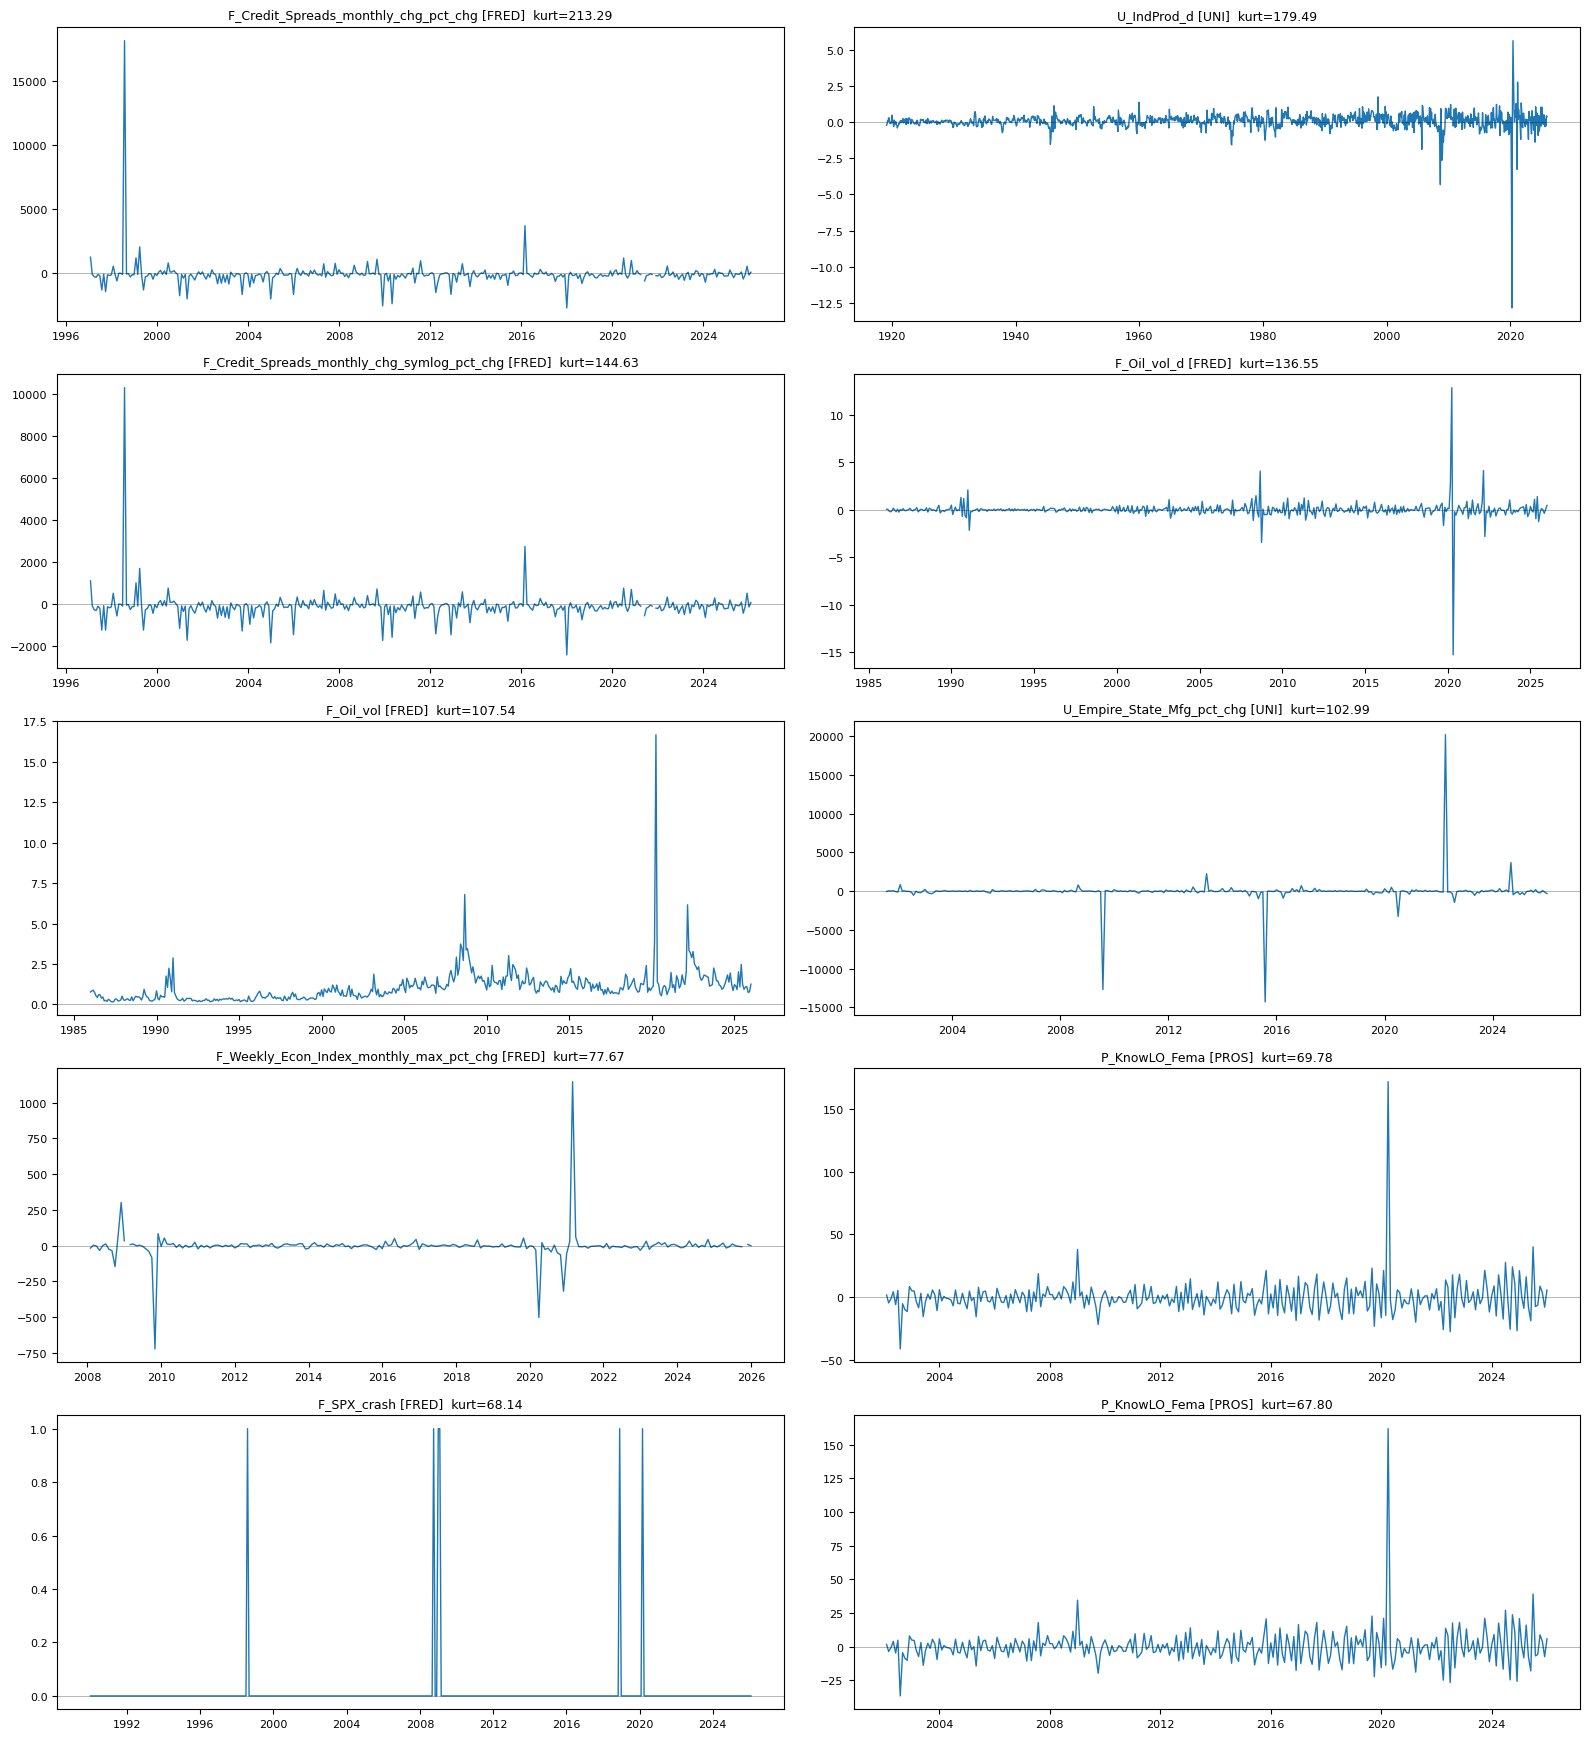

In [116]:
# Skew/kurtosis/scale for all series across sources
# Kurtosis is excess (Fisher) as returned by pandas.Series.kurt()
from IPython.display import display

analysis_wide = wide_all.sort_index()

def scale_bucket(med_abs):
    if pd.isna(med_abs):
        return 'NA', np.nan
    if med_abs == 0:
        return '0s', 0
    if med_abs < 1:
        return '<1', -1
    mag = int(np.floor(np.log10(med_abs)))
    labels = {
        0: '1s',
        1: '10s',
        2: '100s',
        3: '1,000s',
        4: '10,000s',
        5: '100,000s',
        6: 'Millions',
        7: '10 Millions',
        8: '100 Millions',
        9: 'Billions',
        10: '10 Billions',
    }
    return labels.get(mag, f'10^{mag}'), mag

rows = []
for col in analysis_wide.columns:
    s = analysis_wide[col].replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(s)
    if n_obs == 0:
        rows.append({
            'feature': col,
            'short_name': name_map.get(col, col[:30]),
            'source': source_map.get(col, '?'),
            'n_obs': 0,
            'skew': np.nan,
            'kurtosis': np.nan,
            'abs_kurtosis': np.nan,
            'median_abs': np.nan,
            'scale_power': np.nan,
            'scale': 'NA',
        })
        continue

    med_abs = s.abs().median()
    scale_label, scale_pow = scale_bucket(med_abs)
    kurt = s.kurt()
    rows.append({
        'feature': col,
        'short_name': name_map.get(col, col[:30]),
        'source': source_map.get(col, '?'),
        'n_obs': n_obs,
        'skew': s.skew(),
        'kurtosis': kurt,
        'abs_kurtosis': abs(kurt) if pd.notna(kurt) else np.nan,
        'median_abs': med_abs,
        'scale_power': scale_pow,
        'scale': scale_label,
    })

stats_df = pd.DataFrame(rows)
stats_df = stats_df.sort_values('abs_kurtosis', ascending=False).reset_index(drop=True)

out_path = Path('feature_skew_kurtosis_scale.csv')
stats_df.to_csv(out_path, index=False)
print(f'Saved {out_path} with {len(stats_df)} rows')
display(stats_df)

# Plot 10 series with worst (highest absolute) kurtosis
top_kurt = stats_df.dropna(subset=['abs_kurtosis']).head(10)
n = len(top_kurt)
ncols = 2
nrows = int(np.ceil(n / ncols)) if n > 0 else 1
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.5 * nrows))
axes = np.atleast_1d(axes).ravel()

for ax in axes[n:]:
    ax.axis('off')

for i, (_, row) in enumerate(top_kurt.iterrows()):
    col = row['feature']
    s = analysis_wide[col]
    ax = axes[i]
    ax.plot(s.index, s.values, linewidth=1)
    ax.set_title(f"{row['short_name']} [{row['source']}]  kurt={row['kurtosis']:.2f}", fontsize=9)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.4)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


## 3. Source-by-Source Correlation Matrices

In [117]:
def plot_source_corr(wide_df, columns, source_name, name_map, figsize):
    """Plot correlation heatmap for a single source."""
    cols = sorted([c for c in columns if c in wide_df.columns])
    data = wide_df[cols].replace([np.inf, -np.inf], np.nan).dropna()
    short_names = [name_map.get(c, c[:20]) for c in cols]
    
    corr = data.corr()
    corr.index = short_names
    corr.columns = short_names
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu_r', center=0,
                square=True, linewidths=0.1, linecolor='white',
                xticklabels=True, yticklabels=True,
                cbar_kws={'shrink': 0.8, 'label': 'Pearson r'},
                ax=ax)
    ax.set_title(f'{source_name} Correlation Matrix ({len(cols)} features)', fontsize=14, pad=12)
    ax.tick_params(axis='both', labelsize=6)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'corr_{source_name.lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print top 10 absolute correlations
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    pairs = upper.stack().reset_index()
    pairs.columns = ['f1', 'f2', 'r']
    pairs['abs_r'] = pairs['r'].abs()
    top = pairs.nlargest(20, 'abs_r')
    print(f'\nTop 10 correlations within {source_name}:')
    for _, row in top.iterrows():
        print(f'  {row["f1"]:25s} vs {row["f2"]:25s}  r={row["r"]:+.3f}')
    return corr

=== FRED (82 features) ===


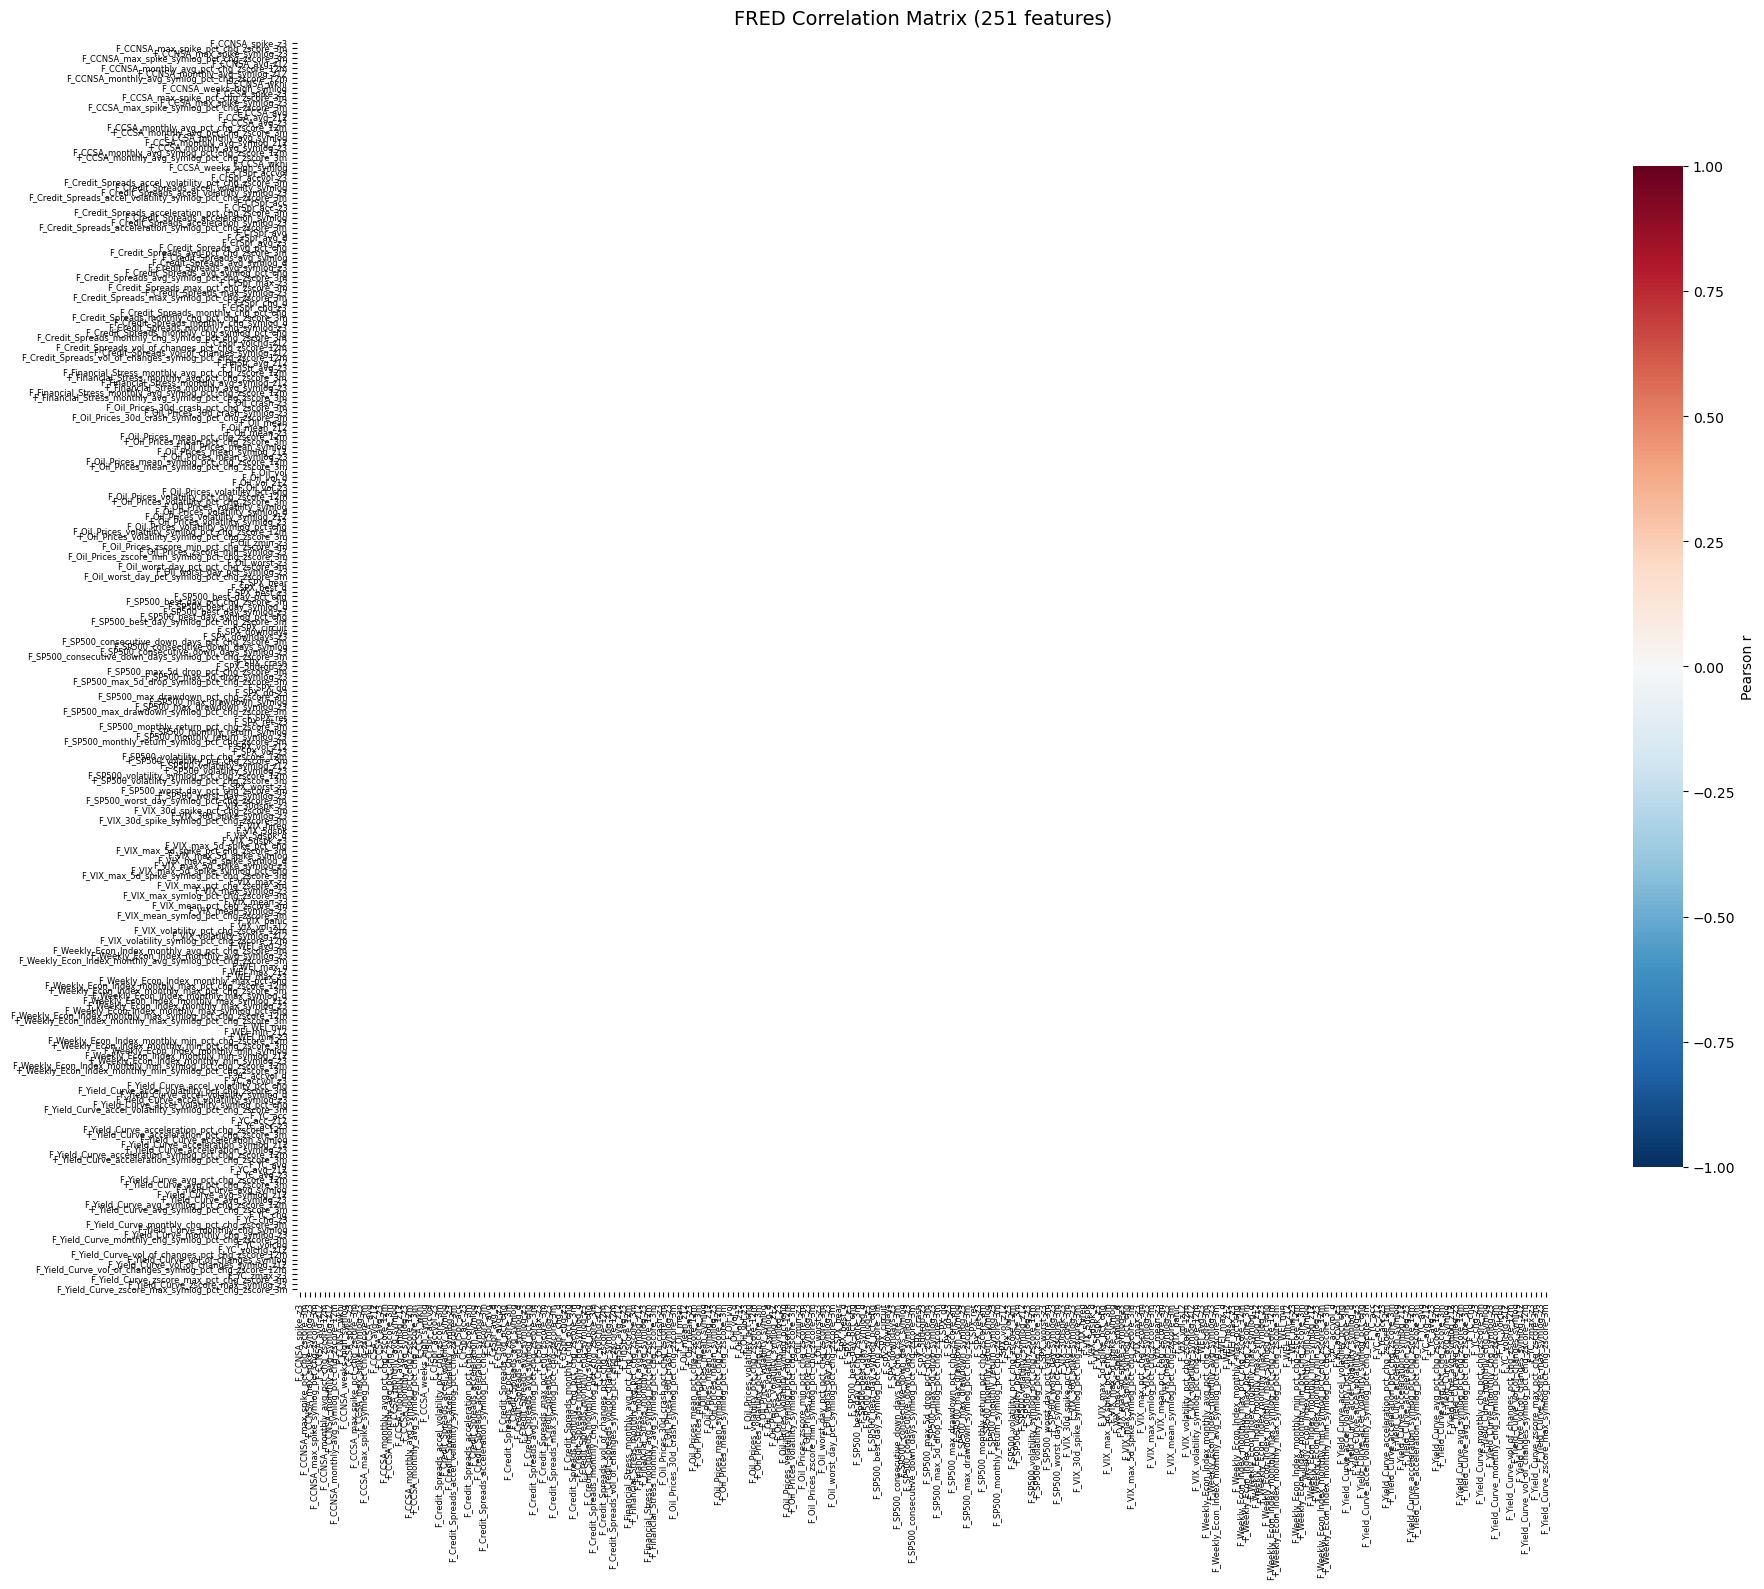


Top 10 correlations within FRED:


In [118]:
# FRED correlation matrix
print('=== FRED (82 features) ===')
corr_fred = plot_source_corr(wide_recent, wide_fred.columns, 'FRED', name_map, (20, 16))

=== UNIFIER (41 features) ===


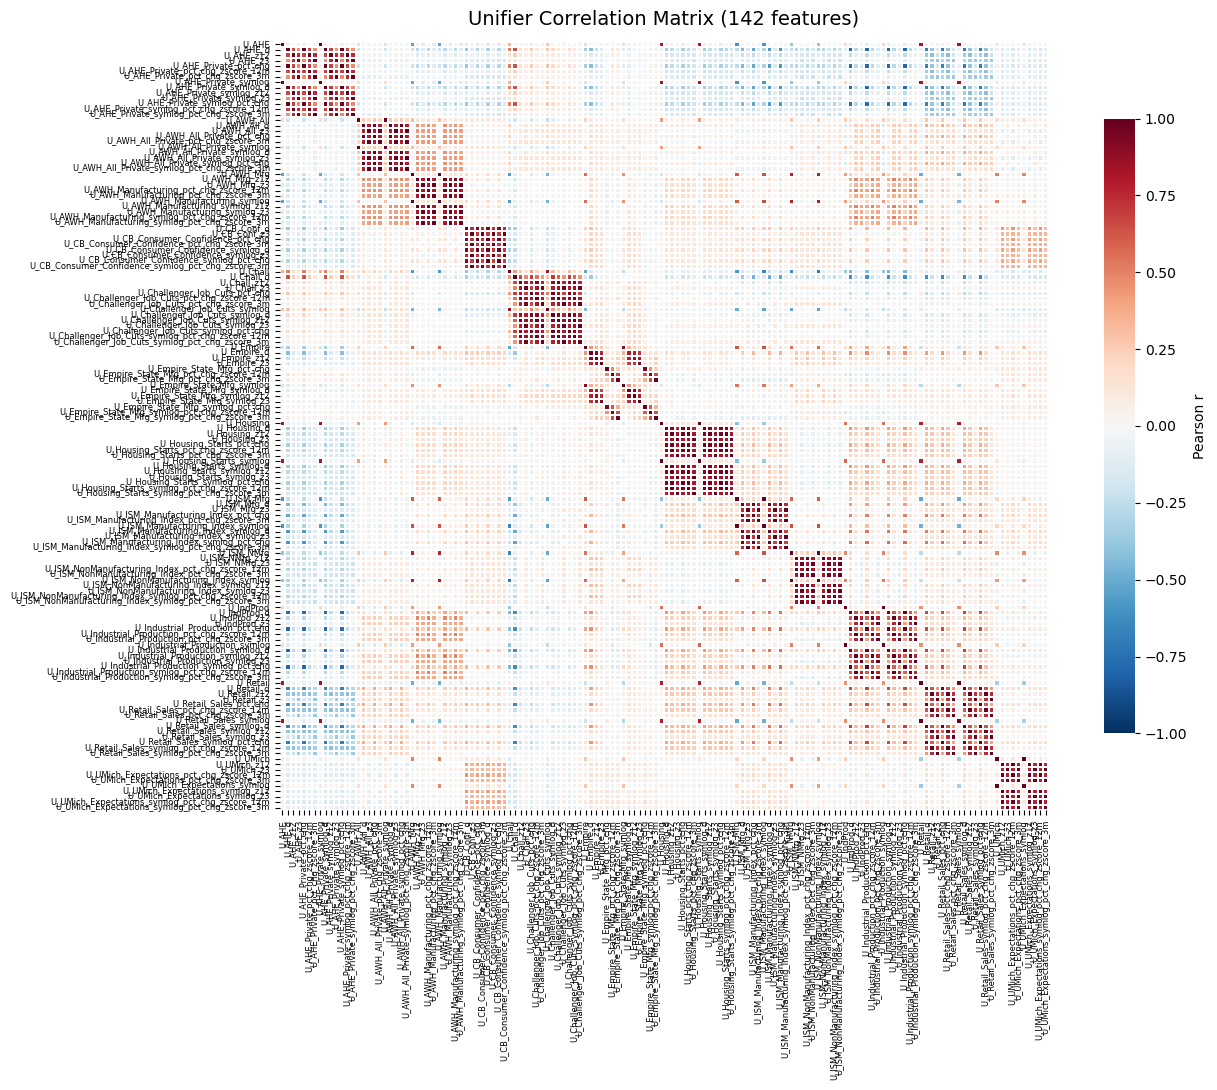


Top 10 correlations within Unifier:
  U_AWH_All_Private_symlog_z3 vs U_AWH_All_Private_symlog_pct_chg_zscore_3m  r=+1.000
  U_AWH_All_Private_pct_chg_zscore_3m vs U_AWH_All_Private_symlog_pct_chg_zscore_3m  r=+1.000
  U_AHE_Private_symlog_z3   vs U_AHE_Private_symlog_pct_chg_zscore_3m  r=+1.000
  U_AHE_Private_pct_chg_zscore_3m vs U_AHE_Private_symlog_pct_chg_zscore_3m  r=+1.000
  U_AWH_All_z3              vs U_AWH_All_Private_symlog_z3  r=+1.000
  U_AHE_Private_pct_chg_zscore_3m vs U_AHE_Private_symlog_z3    r=+1.000
  U_AWH_All_Private_pct_chg_zscore_3m vs U_AWH_All_Private_symlog_z3  r=+1.000
  U_AWH_All_z3              vs U_AWH_All_Private_symlog_pct_chg_zscore_3m  r=+1.000
  U_AWH_All_z3              vs U_AWH_All_Private_pct_chg_zscore_3m  r=+1.000
  U_AWH_Manufacturing_pct_chg_zscore_3m vs U_AWH_Manufacturing_symlog_z3  r=+1.000
  U_AWH_Manufacturing_pct_chg_zscore_3m vs U_AWH_Manufacturing_symlog_pct_chg_zscore_3m  r=+1.000
  U_AHE_z3                  vs U_AHE_Private_symlog_z3

In [119]:
# Unifier correlation matrix
print('=== UNIFIER (41 features) ===')
corr_uni = plot_source_corr(wide_recent, wide_uni.columns, 'Unifier', name_map, (14, 11))

=== PROSPER (53 features) ===


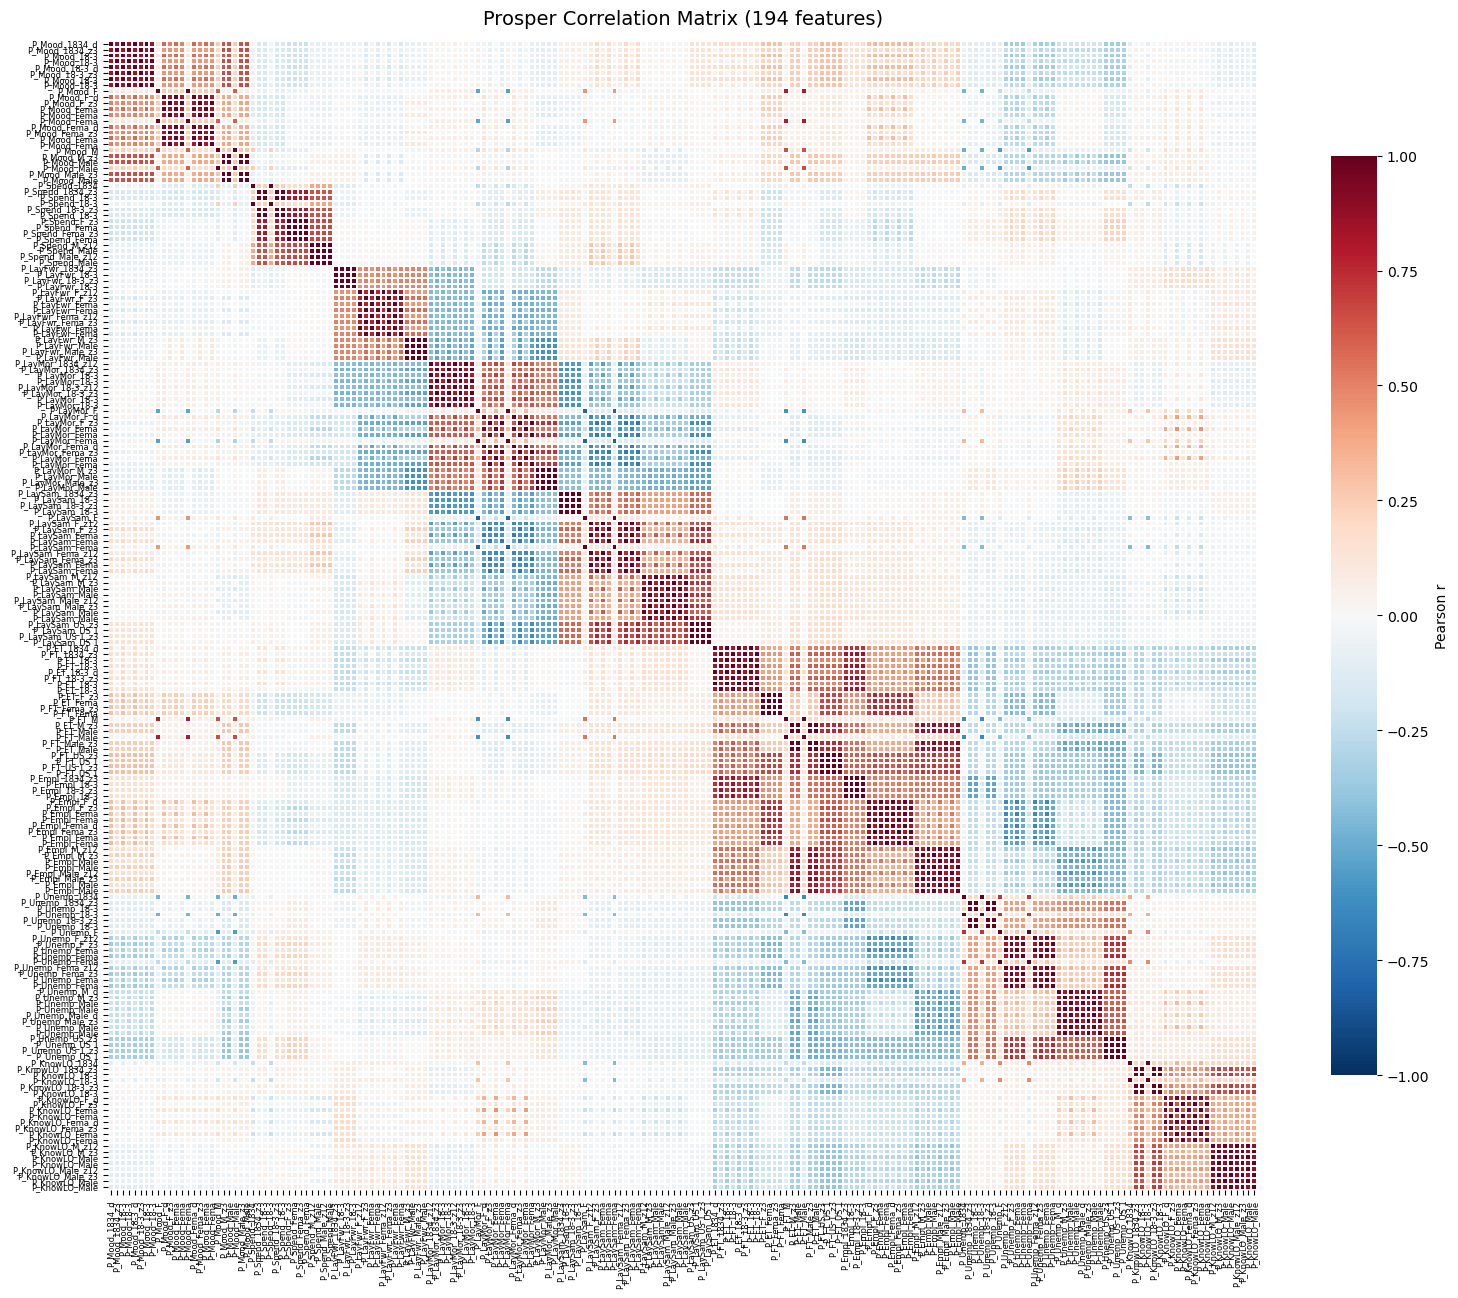


Top 10 correlations within Prosper:
  P_KnowLO_Fema             vs P_KnowLO_Fema              r=+1.000
  P_KnowLO_Male             vs P_KnowLO_Male              r=+1.000
  P_Unemp_Male              vs P_Unemp_Male               r=+1.000
  P_Unemp_US 1              vs P_Unemp_US 1               r=+1.000
  P_Empl_Male               vs P_Empl_Male                r=+1.000
  P_Mood_Fema_z3            vs P_Mood_Fema                r=+1.000
  P_Mood_Male_z3            vs P_Mood_Male                r=+1.000
  P_FT_Fema                 vs P_FT_Fema                  r=+1.000
  P_FT_US 1                 vs P_FT_US 1                  r=+1.000
  P_Unemp_Fema              vs P_Unemp_Fema               r=+1.000
  P_FT_Male                 vs P_FT_Male                  r=+1.000
  P_KnowLO_F_z3             vs P_KnowLO_Fema_z3           r=+1.000
  P_Unemp_M_z3              vs P_Unemp_Male_z3            r=+1.000
  P_KnowLO_M_z3             vs P_KnowLO_Male_z3           r=+1.000
  P_Empl_Fema            

In [120]:
# Prosper correlation matrix
print('=== PROSPER (53 features) ===')
corr_pros = plot_source_corr(wide_recent, wide_pros.columns, 'Prosper', name_map, (16, 13))

## 4. Combined 176x176 Correlation Matrix

Combined correlation matrix: (587, 587)
Rows used for computation: 0


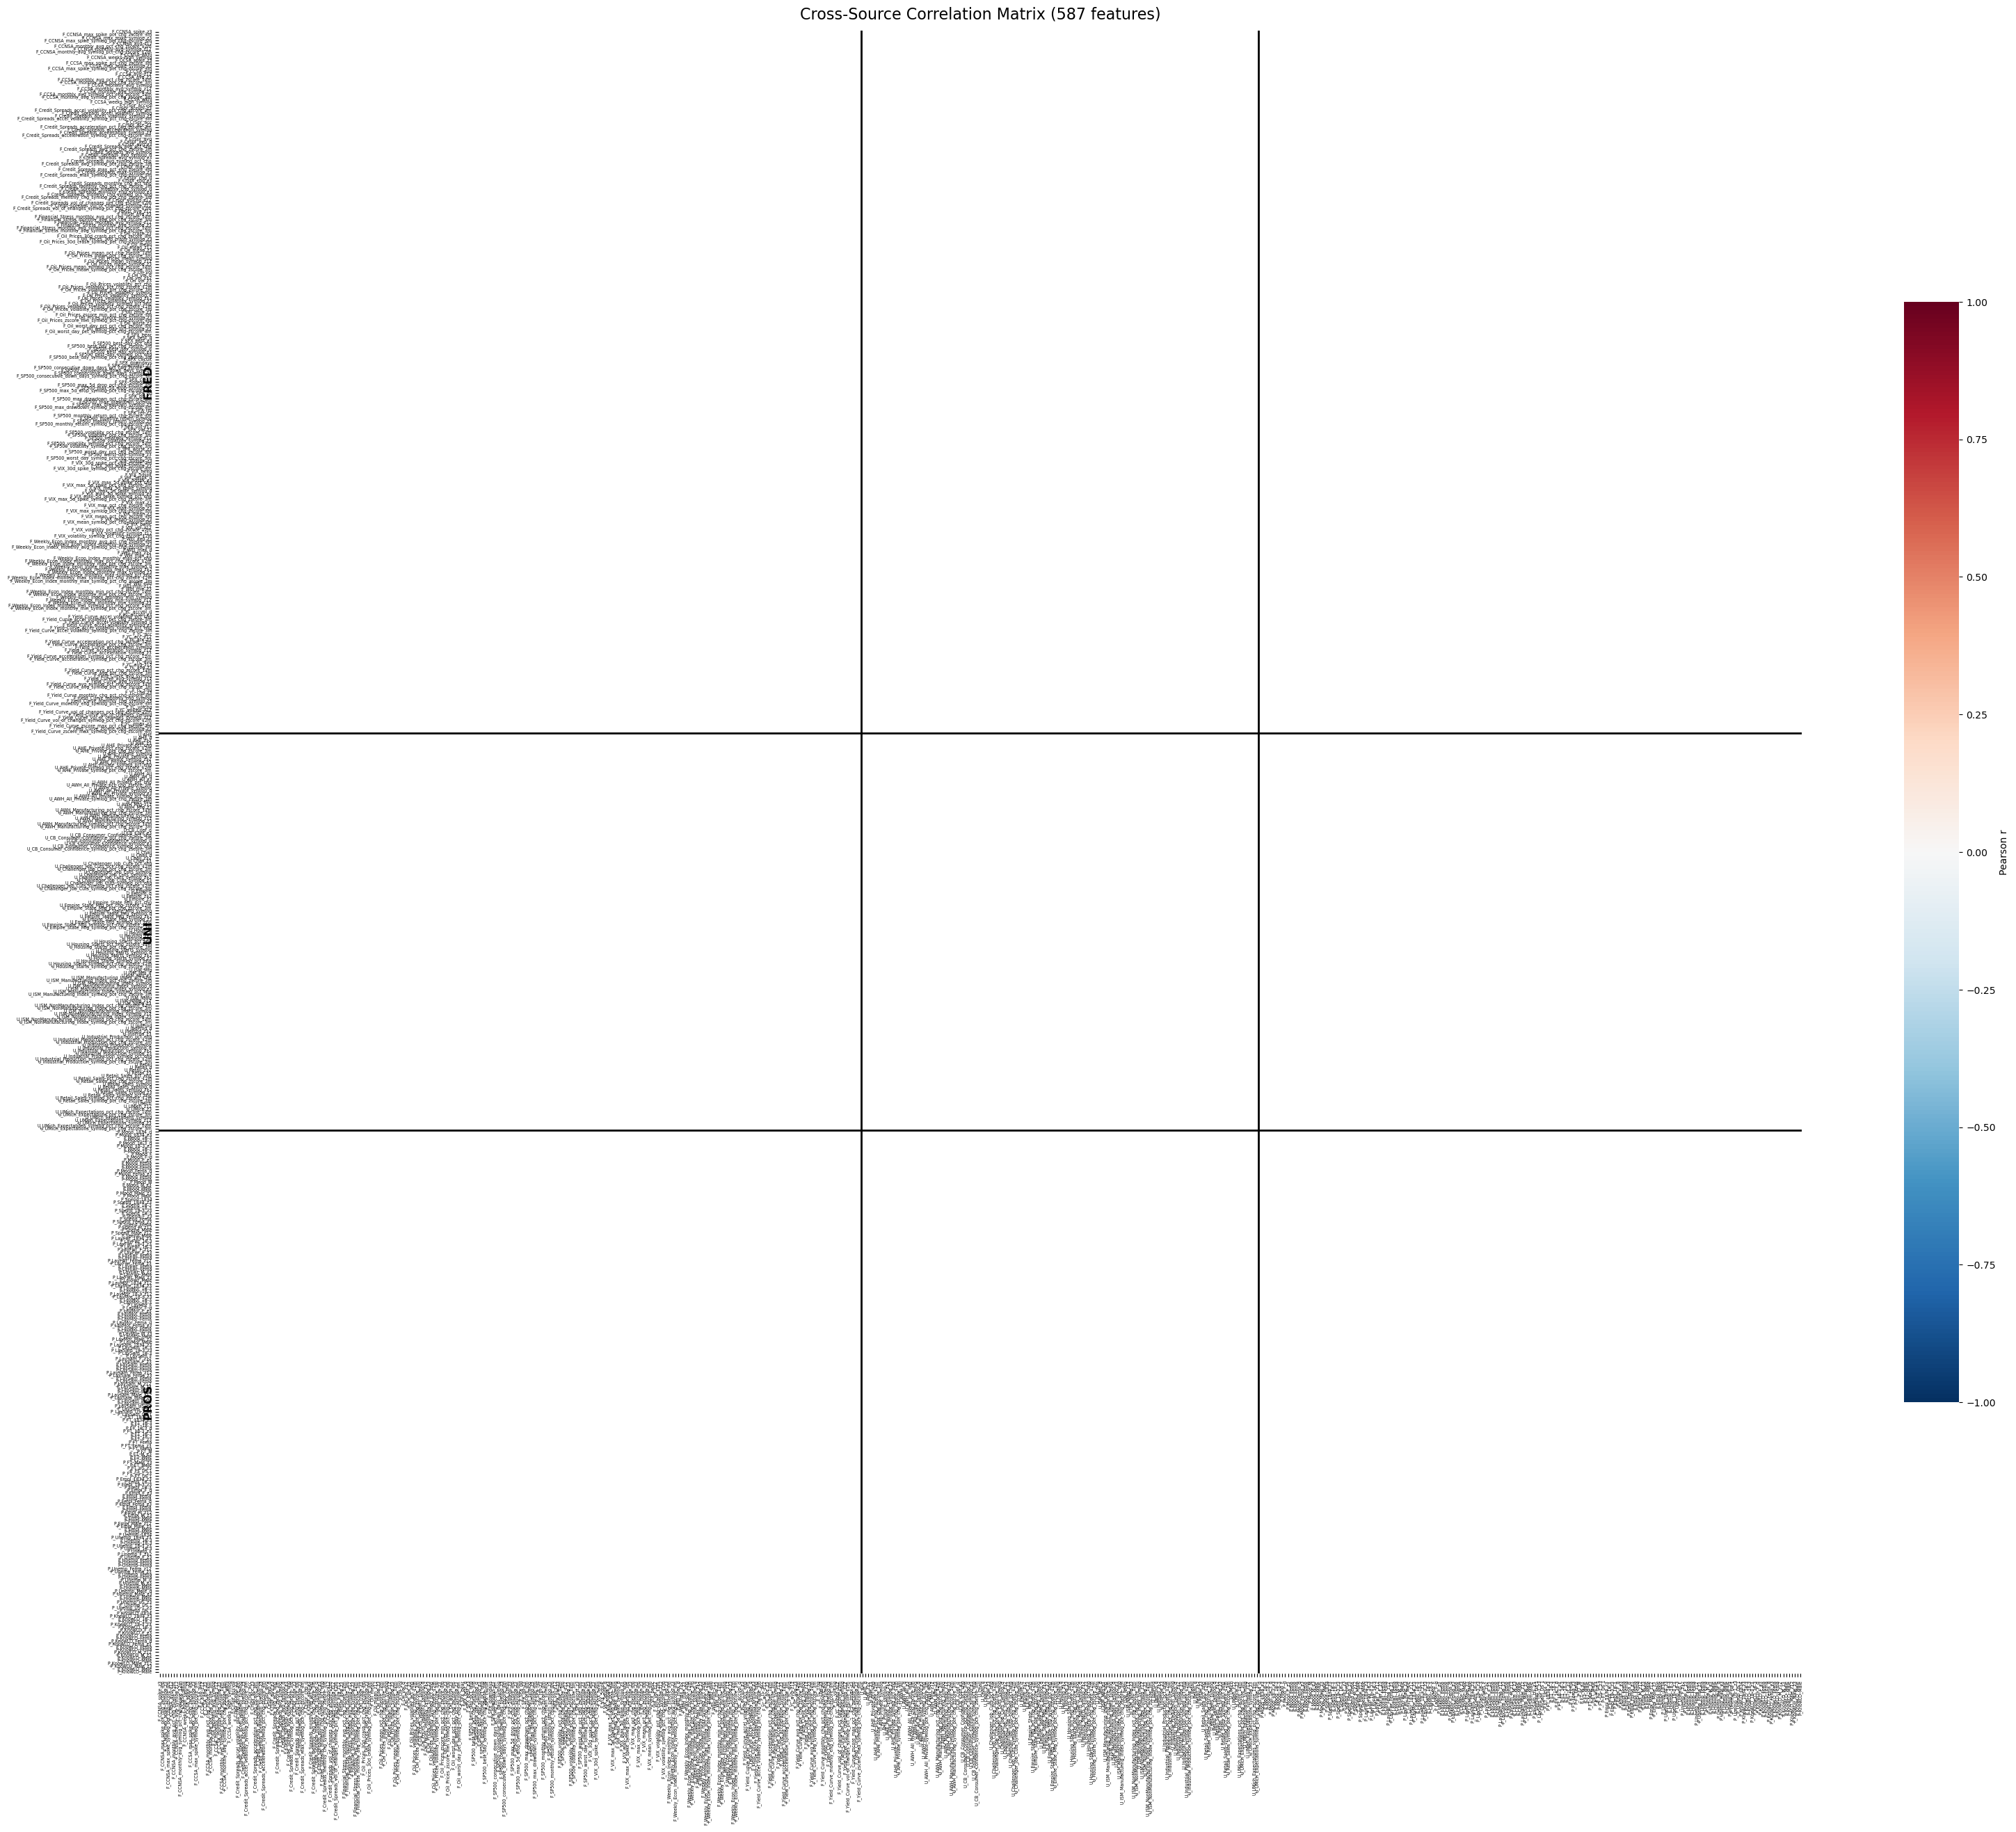

Saved to output.png


In [121]:
# Order: FRED, then Unifier, then Prosper
fred_cols = sorted([c for c in wide_fred.columns if c in wide_recent.columns])
uni_cols  = sorted([c for c in wide_uni.columns if c in wide_recent.columns])
pros_cols = sorted([c for c in wide_pros.columns if c in wide_recent.columns])
all_cols  = fred_cols + uni_cols + pros_cols

data = wide_recent[all_cols].replace([np.inf, -np.inf], np.nan).dropna()
short_labels = [name_map.get(c, c[:20]) for c in all_cols]

corr_all = data.corr()
corr_all.index = short_labels
corr_all.columns = short_labels

print(f'Combined correlation matrix: {corr_all.shape}')
print(f'Rows used for computation: {len(data)}')

# Plot
fig, ax = plt.subplots(figsize=(32, 28))
sns.heatmap(corr_all, vmin=-1, vmax=1, cmap='RdBu_r', center=0,
            square=True, linewidths=0, 
            xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.6, 'label': 'Pearson r'},
            ax=ax)

# Add source boundary lines
n_fred = len(fred_cols)
n_uni  = len(uni_cols)
n_pros = len(pros_cols)

for boundary in [n_fred, n_fred + n_uni]:
    ax.axhline(y=boundary, color='black', linewidth=2)
    ax.axvline(x=boundary, color='black', linewidth=2)

# Source labels on sides
ax.text(-2, n_fred/2, 'FRED', ha='right', va='center', fontsize=12, fontweight='bold', rotation=90)
ax.text(-2, n_fred + n_uni/2, 'UNI', ha='right', va='center', fontsize=12, fontweight='bold', rotation=90)
ax.text(-2, n_fred + n_uni + n_pros/2, 'PROS', ha='right', va='center', fontsize=12, fontweight='bold', rotation=90)

ax.set_title(f'Cross-Source Correlation Matrix ({len(all_cols)} features)', fontsize=16, pad=12)
ax.tick_params(axis='both', labelsize=4.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('output.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to output.png')

## 5. Top Cross-Source Correlations

In [122]:
# Build source lookup for short names
short_source = {}
for c in fred_cols:
    short_source[name_map[c]] = 'FRED'
for c in uni_cols:
    short_source[name_map[c]] = 'UNI'
for c in pros_cols:
    short_source[name_map[c]] = 'PROS'

# Get upper triangle pairs
upper = corr_all.where(np.triu(np.ones(corr_all.shape), k=1).astype(bool))
pairs = upper.stack().reset_index()
pairs.columns = ['f1', 'f2', 'r']
pairs['s1'] = pairs['f1'].map(short_source)
pairs['s2'] = pairs['f2'].map(short_source)
pairs['abs_r'] = pairs['r'].abs()

# Cross-source only
cross = pairs[pairs['s1'] != pairs['s2']].copy()
top_cross = cross.nlargest(30, 'abs_r')

print('Top 30 Cross-Source Correlations')
print('=' * 90)
for i, (_, row) in enumerate(top_cross.iterrows(), 1):
    print(f'  {i:2d}. [{row["s1"]:4s}] {row["f1"]:28s} vs [{row["s2"]:4s}] {row["f2"]:28s}  r={row["r"]:+.3f}')

# Summary by source pair
print('\nCross-source pairs with |r| > 0.5:')
for pair_name, s1, s2 in [('FRED-UNI', 'FRED', 'UNI'), ('FRED-PROS', 'FRED', 'PROS'), ('UNI-PROS', 'UNI', 'PROS')]:
    mask = ((cross['s1'] == s1) & (cross['s2'] == s2)) | ((cross['s1'] == s2) & (cross['s2'] == s1))
    high = cross[mask & (cross['abs_r'] > 0.5)]
    print(f'  {pair_name}: {len(high)} pairs')

Top 30 Cross-Source Correlations

Cross-source pairs with |r| > 0.5:
  FRED-UNI: 0 pairs
  FRED-PROS: 0 pairs
  UNI-PROS: 0 pairs


## 6. Cross-Source VIF Analysis

In [123]:
def iterative_vif_pruning(df_wide, features, threshold=10.0, verbose=True):
    """Iteratively remove highest-VIF feature until all below threshold."""
    cols = [c for c in features if c in df_wide.columns]
    X = df_wide[cols].replace([np.inf, -np.inf], np.nan).dropna()
    X = X.loc[:, X.var() > 0]
    removed = []
    iteration = 0
    while len(X.columns) > 2:
        iteration += 1
        X_const = X.copy()
        X_const['_const'] = 1.0
        vifs = {}
        for col in [c for c in X_const.columns if c != '_const']:
            try:
                vifs[col] = variance_inflation_factor(X_const.values, X_const.columns.get_loc(col))
            except:
                vifs[col] = np.inf
        max_col = max(vifs, key=vifs.get)
        max_vif = vifs[max_col]
        if max_vif <= threshold:
            break
        X = X.drop(columns=[max_col])
        removed.append((max_col, round(max_vif, 2)))
        if verbose and iteration <= 20:
            short = name_map.get(max_col, max_col[:30])
            src = source_map.get(max_col, '?')
            print(f'  Iter {iteration:3d}: Removed [{src:4s}] {short:30s} (VIF={max_vif:.1f})')
        elif verbose and iteration == 21:
            print(f'  ... (continuing)')
    if verbose and iteration > 20:
        print(f'  Total iterations: {iteration}')
    return X.columns.tolist(), removed

# Drop features with >30% NaN
nan_pct = wide_recent.isna().mean()
good_features = [f for f in all_cols if nan_pct.get(f, 1.0) <= 0.3]
dropped_nan = [f for f in all_cols if f not in good_features]
if dropped_nan:
    print(f'Dropped {len(dropped_nan)} features with >30% NaN:')
    for f in dropped_nan:
        print(f'  {name_map.get(f, f)} ({nan_pct[f]*100:.0f}% NaN)')

print(f'\nStarting VIF pruning with {len(good_features)} features (threshold=10.0)...')
final_survivors, final_removed = iterative_vif_pruning(
    wide_recent, good_features, threshold=10.0
)

print(f'\nFinal: {len(final_survivors)} features survived (removed {len(final_removed)})')

# Count by source
surv_fred = [f for f in final_survivors if source_map.get(f) == 'FRED']
surv_uni  = [f for f in final_survivors if source_map.get(f) == 'UNI']
surv_pros = [f for f in final_survivors if source_map.get(f) == 'PROS']
print(f'\nBy source:')
print(f'  FRED:    {len(surv_fred):3d} / 82  survived')
print(f'  Unifier: {len(surv_uni):3d} / 41  survived')
print(f'  Prosper: {len(surv_pros):3d} / 53  survived')


Starting VIF pruning with 587 features (threshold=10.0)...

Final: 0 features survived (removed 0)

By source:
  FRED:      0 / 82  survived
  Unifier:   0 / 41  survived
  Prosper:   0 / 53  survived


## 7. Final VIF Verification

In [124]:
# Compute final VIF for all survivors
cols = [c for c in final_survivors if c in wide_recent.columns]
X = wide_recent[cols].replace([np.inf, -np.inf], np.nan).dropna()
X = X.loc[:, X.var() > 0]
X_const = X.copy()
X_const['_const'] = 1.0

vif_final = []
for col in [c for c in X_const.columns if c != '_const']:
    try:
        vif = variance_inflation_factor(X_const.values, X_const.columns.get_loc(col))
    except:
        vif = np.nan
    vif_final.append({
        'feature': col,
        'short_name': name_map.get(col, col[:30]),
        'source': source_map.get(col, '?'),
        'VIF': round(vif, 2)
    })

vif_df = pd.DataFrame(vif_final).sort_values('VIF', ascending=False)

print('Final VIF Verification (all should be <= 10):')
print('=' * 70)
for _, row in vif_df.iterrows():
    print(f'  [{row["source"]:4s}] VIF={row["VIF"]:6.2f}  {row["short_name"]}')

print(f'\nMax VIF: {vif_df["VIF"].max():.2f}')
print(f'Mean VIF: {vif_df["VIF"].mean():.2f}')
print(f'Features with VIF > 10: {(vif_df["VIF"] > 10).sum()}')

KeyError: 'VIF'

## 8. Summary & Output

In [125]:
print('CROSS-SOURCE SELECTED FEATURES')
print('=' * 70)
print(f'Total: {len(final_survivors)}')
print(f'  FRED:    {len(surv_fred)}')
print(f'  Unifier: {len(surv_uni)}')
print(f'  Prosper: {len(surv_pros)}')

print(f'\n--- FRED ({len(surv_fred)}) ---')
for f in sorted(surv_fred):
    print(f'  {name_map[f]:30s}  {f}')

print(f'\n--- Unifier ({len(surv_uni)}) ---')
for f in sorted(surv_uni):
    print(f'  {name_map[f]:30s}  {f}')

print(f'\n--- Prosper ({len(surv_pros)}) ---')
for f in sorted(surv_pros):
    print(f'  {name_map[f]:30s}  {f}')

# Features that were removed (cross-source redundancy)
print(f'\n\nREMOVED FEATURES ({len(final_removed)}):')
for f, vif in final_removed:
    src = source_map.get(f, '?')
    short = name_map.get(f, f[:30])
    print(f'  [{src:4s}] {short:30s}  VIF={vif}')

CROSS-SOURCE SELECTED FEATURES
Total: 0
  FRED:    0
  Unifier: 0
  Prosper: 0

--- FRED (0) ---

--- Unifier (0) ---

--- Prosper (0) ---


REMOVED FEATURES (0):


## 9. Feature Correlations with NFP Target (MoM Diff)

Compute Pearson correlation between ALL 176 features (before any VIF selection) and the NFP target MoM difference to assess explanatory power of each feature group.

In [126]:
# Load NFP target and compute MoM difference
target = pd.read_parquet('data/NFP_target/y_nsa_first_release.parquet')
target['y_diff'] = target['y'].diff()
target = target.dropna(subset=['y_diff'])
target['date'] = pd.to_datetime(target['ds'])
target = target.set_index('date')[['y_diff']]
print(f'Target: {len(target)} months, {target.index.min().strftime("%Y-%m")} to {target.index.max().strftime("%Y-%m")}')
print(f'Target MoM diff: mean={target["y_diff"].mean():.0f}, std={target["y_diff"].std():.0f}')

# Use ALL features (full wide_all, not just 2010+)
# Forward-fill to handle staggered start dates, then join with target
wide_for_corr = wide_all.ffill()
merged = wide_for_corr.join(target, how='inner')
print(f'\nMerged shape: {merged.shape} ({merged.shape[1]-1} features x {merged.shape[0]} months)')
print(f'Date range: {merged.index.min().strftime("%Y-%m")} to {merged.index.max().strftime("%Y-%m")}')

Target: 430 months, 1990-03 to 2025-12
Target MoM diff: mean=122, std=1452

Merged shape: (430, 588) (587 features x 430 months)
Date range: 1990-03 to 2025-12


In [127]:
# Compute correlation of each feature with target MoM diff
all_feature_cols = [c for c in merged.columns if c != 'y_diff']

corr_records = []
for feat in all_feature_cols:
    valid = merged[[feat, 'y_diff']].replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid) >= 20:
        r = valid[feat].corr(valid['y_diff'])
        corr_records.append({
            'feature': feat,
            'short_name': name_map.get(feat, feat[:30]),
            'source': source_map.get(feat, '?'),
            'r': round(r, 4),
            'abs_r': round(abs(r), 4),
            'n_obs': len(valid),
        })

corr_df = pd.DataFrame(corr_records).sort_values('abs_r', ascending=False).reset_index(drop=True)
corr_df.index = corr_df.index + 1  # 1-indexed rank

# Identify feature group for analysis
def get_feature_group(feat, source):
    if source == 'UNI':
        base, _ = get_transform_suffix(feat)
        return f'UNI_{base}'
    elif source == 'PROS':
        parts = feat.split(' | ')
        if len(parts) >= 2:
            answer = parts[1].strip()
            for key in ['Consumer Mood Index', 'Consumer Spending Forecast']:
                if key in parts[0]:
                    return f'PROS_{key.split()[-1]}'
            return f'PROS_{answer[:20]}'
        return 'PROS_other'
    else:  # FRED
        base, _ = get_transform_suffix(feat)
        # Group by prefix
        for prefix in ['CCNSA', 'CCSA', 'Credit_Spreads', 'Financial_Stress',
                       'ICNSA', 'ICSA', 'Oil_Prices', 'Oil_worst',
                       'SP500', 'VIX', 'Weekly_Econ_Index', 'Yield_Curve']:
            if base.startswith(prefix):
                return f'FRED_{prefix}'
        return f'FRED_{base}'

corr_df['group'] = corr_df.apply(lambda row: get_feature_group(row['feature'], row['source']), axis=1)

print(f'Feature-Target Correlation Ranking (all {len(corr_df)} features)')
print('=' * 100)
print(f'{"Rank":>4s}  {"Source":5s}  {"Short Name":30s}  {"r":>8s}  {"|r|":>6s}  {"n":>4s}')
print('-' * 100)
for idx, row in corr_df.iterrows():
    print(f'{idx:4d}  [{row["source"]:4s}] {row["short_name"]:30s}  {row["r"]:+8.4f}  {row["abs_r"]:6.4f}  {row["n_obs"]:4d}')

Feature-Target Correlation Ranking (all 587 features)
Rank  Source  Short Name                             r     |r|     n
----------------------------------------------------------------------------------------------------
   1  [FRED] F_CCNSA_avg_z12                  -0.6407  0.6407   425
   2  [UNI ] U_AHE_d                          -0.6329  0.6329   237
   3  [FRED] F_CCNSA_monthly_avg_pct_chg_zscore_12m   -0.6304  0.6304   425
   4  [FRED] F_CCNSA_monthly_avg_symlog_z12   -0.6255  0.6255   425
   5  [FRED] F_CCNSA_monthly_avg_symlog_pct_chg_zscore_12m   -0.6246  0.6246   425
   6  [UNI ] U_AHE_Private_pct_chg            -0.6170  0.6170   237
   7  [UNI ] U_AHE_Private_symlog_d           -0.6138  0.6138   237
   8  [UNI ] U_AHE_Private_symlog_pct_chg     -0.6074  0.6074   237
   9  [FRED] F_Weekly_Econ_Index_monthly_max_symlog_d   +0.6017  0.6017   215
  10  [UNI ] U_Industrial_Production_symlog_d   +0.5704  0.5704   430
  11  [UNI ] U_Industrial_Production_symlog_pct_chg   +0.5686

In [128]:
# Group-level analysis: average |r| by feature group
group_stats = corr_df.groupby('group').agg(
    mean_abs_r=('abs_r', 'mean'),
    max_abs_r=('abs_r', 'max'),
    n_features=('abs_r', 'count'),
    best_feature=('abs_r', lambda x: corr_df.loc[x.idxmax(), 'short_name']),
    best_r=('r', lambda x: corr_df.loc[corr_df.loc[x.index, 'abs_r'].idxmax(), 'r']),
).sort_values('mean_abs_r', ascending=False)

print('Feature Group Rankings by Average |r| with NFP MoM Diff')
print('=' * 110)
print(f'{"Group":35s}  {"mean |r|":>8s}  {"max |r|":>7s}  {"#feat":>5s}  {"Best Feature":>30s}  {"r":>8s}')
print('-' * 110)
for grp, row in group_stats.iterrows():
    print(f'{grp:35s}  {row["mean_abs_r"]:8.4f}  {row["max_abs_r"]:7.4f}  {row["n_features"]:5.0f}  {row["best_feature"]:>30s}  {row["best_r"]:+8.4f}')

# Highlight CCSA, CCNSA, Credit Spreads
print('\n\n' + '=' * 80)
print('FOCUS: CCSA, CCNSA, Credit Spreads Feature Groups')
print('=' * 80)
for grp_prefix in ['FRED_CCSA', 'FRED_CCNSA', 'FRED_Credit_Spreads']:
    grp_feats = corr_df[corr_df['group'] == grp_prefix].copy()
    if grp_feats.empty:
        continue
    print(f'\n--- {grp_prefix} ({len(grp_feats)} features, mean |r|={grp_feats["abs_r"].mean():.4f}) ---')
    for _, row in grp_feats.iterrows():
        vif_status = 'KEPT' if row['feature'] in final_survivors else 'VIF-removed'
        print(f'  {row["short_name"]:30s}  r={row["r"]:+.4f}  |r|={row["abs_r"]:.4f}  [{vif_status}]')

Feature Group Rankings by Average |r| with NFP MoM Diff
Group                                mean |r|  max |r|  #feat                    Best Feature         r
--------------------------------------------------------------------------------------------------------------
UNI_AHE_Private_pct_chg                0.6170   0.6170      1           U_AHE_Private_pct_chg   -0.6170
UNI_AHE_Private_symlog_pct_chg         0.6074   0.6074      1    U_AHE_Private_symlog_pct_chg   -0.6074
UNI_Industrial_Production_symlog_pct_chg    0.5686   0.5686      1  U_Industrial_Production_symlog_pct_chg   +0.5686
UNI_Industrial_Production_pct_chg      0.5581   0.5581      1  U_Industrial_Production_pct_chg   +0.5581
FRED_CCNSA                             0.4327   0.6407     10                 F_CCNSA_avg_z12   -0.6407
UNI_Retail_Sales_symlog_pct_chg        0.3812   0.3812      1   U_Retail_Sales_symlog_pct_chg   +0.3812
UNI_Retail_Sales_pct_chg               0.3789   0.3789      1          U_Retail_Sales_pct_c

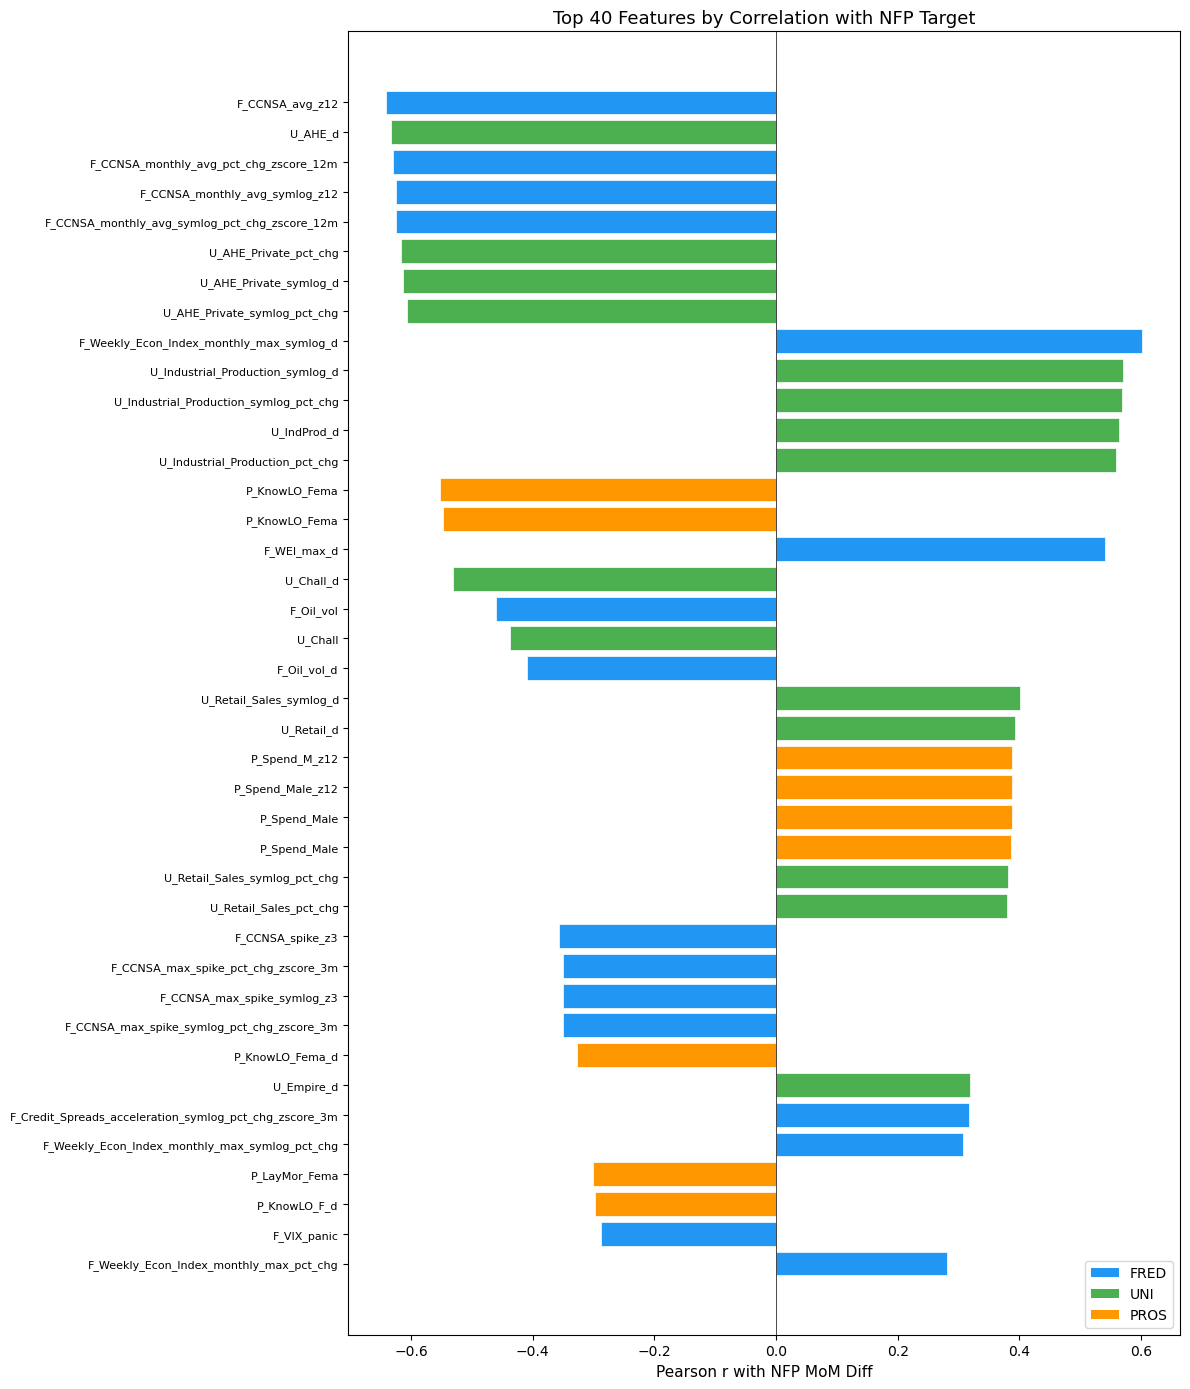

Saved to target_correlations.png


In [129]:
# Horizontal bar chart: top 40 features by |r| with target
top_n = 40
top_feats = corr_df.head(top_n).copy()
top_feats = top_feats.iloc[::-1]  # reverse for bottom-to-top plotting

# Color by source
colors = {'FRED': '#2196F3', 'UNI': '#4CAF50', 'PROS': '#FF9800'}
bar_colors = [colors.get(s, 'gray') for s in top_feats['source']]

fig, ax = plt.subplots(figsize=(12, 14))
bars = ax.barh(range(len(top_feats)), top_feats['r'], color=bar_colors, edgecolor='white', linewidth=0.5)
ax.set_yticks(range(len(top_feats)))
ax.set_yticklabels(top_feats['short_name'], fontsize=8)
ax.set_xlabel('Pearson r with NFP MoM Diff', fontsize=11)
ax.set_title(f'Top {top_n} Features by Correlation with NFP Target', fontsize=13)
ax.axvline(x=0, color='black', linewidth=0.5)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=s) for s, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('target_correlations.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to target_correlations.png')

In [130]:
# Summary: what the VIF pruning removed that had high target correlation
print('HIGH TARGET-CORRELATED FEATURES LOST TO VIF PRUNING')
print('=' * 90)
print('(Features with |r| >= 0.10 that were VIF-removed)')
print()

removed_set = set(f for f, _ in final_removed)
lost_valuable = corr_df[(corr_df['feature'].isin(removed_set)) & (corr_df['abs_r'] >= 0.10)]
lost_valuable = lost_valuable.sort_values('abs_r', ascending=False)

for _, row in lost_valuable.iterrows():
    vif_val = dict(final_removed).get(row['feature'], '?')
    print(f'  {row["short_name"]:30s}  r={row["r"]:+.4f}  |r|={row["abs_r"]:.4f}  VIF={vif_val}  [{row["source"]}]')

print(f'\nTotal lost with |r|>=0.10: {len(lost_valuable)} features')
print(f'Total lost with |r|>=0.15: {len(lost_valuable[lost_valuable["abs_r"] >= 0.15])} features')

# Compare: avg target correlation of VIF-kept vs VIF-removed
kept_corrs = corr_df[~corr_df['feature'].isin(removed_set)]['abs_r']
lost_corrs = corr_df[corr_df['feature'].isin(removed_set)]['abs_r']
print(f'\nAvg |r| with target:')
print(f'  VIF-kept ({len(kept_corrs)} features):    mean={kept_corrs.mean():.4f}, median={kept_corrs.median():.4f}')
print(f'  VIF-removed ({len(lost_corrs)} features): mean={lost_corrs.mean():.4f}, median={lost_corrs.median():.4f}')

HIGH TARGET-CORRELATED FEATURES LOST TO VIF PRUNING
(Features with |r| >= 0.10 that were VIF-removed)


Total lost with |r|>=0.10: 0 features
Total lost with |r|>=0.15: 0 features

Avg |r| with target:
  VIF-kept (587 features):    mean=0.1099, median=0.0714
  VIF-removed (0 features): mean=nan, median=nan


## 10. Comprehensive Feature Analysis CSV

For each of the 176 features: target correlation, number of highly-correlated peers (|r|>0.5 cross-source), which those peers are, and sum of all cross-feature |correlations|.

In [131]:
# Build comprehensive feature analysis across ALL sources
# Use the full wide_all (ffilled) joined with target for correlations

wide_for_analysis = wide_all.ffill()
merged_full = wide_for_analysis.join(target, how='inner')
all_feature_cols = [c for c in merged_full.columns if c != 'y_diff']

# 1. Compute target correlation for every feature
target_corrs = {}
for feat in all_feature_cols:
    valid = merged_full[[feat, 'y_diff']].replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid) >= 20:
        target_corrs[feat] = round(valid[feat].corr(valid['y_diff']), 4)
    else:
        target_corrs[feat] = np.nan

# 2. Compute full cross-feature correlation matrix (all 176 features, across all sources)
analysis_data = wide_for_analysis[all_feature_cols].replace([np.inf, -np.inf], np.nan)
# Use 2005+ for broader coverage (Prosper starts ~2007, WEI starts ~2008)
analysis_recent = analysis_data.loc[analysis_data.index >= '2005-01-01'].dropna(how='all', axis=1)
# Pairwise correlation (uses pairwise complete obs by default)
cross_corr = analysis_recent.corr()

print(f'Cross-correlation matrix: {cross_corr.shape}')

# 3. For each feature: count peers with |r| > 0.5, list them, and sum of all |r|
rows = []
for feat in all_feature_cols:
    if feat not in cross_corr.columns:
        continue
    
    feat_corrs = cross_corr[feat].drop(feat, errors='ignore')  # exclude self
    
    # Peers with |r| > 0.5
    high_peers = feat_corrs[feat_corrs.abs() > 0.5].sort_values(key=abs, ascending=False)
    high_peer_names = []
    for peer, r_val in high_peers.items():
        short_peer = name_map.get(peer, peer[:25])
        high_peer_names.append(f'{short_peer} ({r_val:+.2f})')
    
    # Sum of all |r| (measure of total redundancy)
    sum_abs_r = round(feat_corrs.abs().sum(), 2)
    mean_abs_r = round(feat_corrs.abs().mean(), 4)
    
    rows.append({
        'feature': feat,
        'short_name': name_map.get(feat, feat[:30]),
        'source': source_map.get(feat, '?'),
        'target_r': target_corrs.get(feat, np.nan),
        'target_abs_r': abs(target_corrs.get(feat, 0)),
        'n_high_corr_peers': len(high_peers),
        'sum_abs_r_all': sum_abs_r,
        'mean_abs_r_all': mean_abs_r,
        'high_corr_peers': '; '.join(high_peer_names) if high_peer_names else '',
    })

feature_df = pd.DataFrame(rows)
feature_df = feature_df.sort_values('target_abs_r', ascending=False).reset_index(drop=True)
feature_df.index = feature_df.index + 1  # 1-indexed rank
feature_df.index.name = 'rank'

# Save to CSV
feature_df.to_csv('feature_analysis.csv')
print(f'Saved feature_analysis.csv with {len(feature_df)} features')
print(f'Columns: {list(feature_df.columns)}')

# Print summary
sep = '=' * 100
dash = '-' * 100
print(f'\n{sep}')
print('Top 30 features by target correlation (with redundancy info):')
print(sep)
print(f'{"Rank":>4s}  {"Source":5s}  {"Short Name":28s}  {"r(target)":>10s}  {"#Peers":>6s}  {"SumAbsR":>8s}  Top Peers')
print(dash)
for idx, row in feature_df.head(30).iterrows():
    peers_preview = row['high_corr_peers'][:60] + '...' if len(str(row['high_corr_peers'])) > 60 else row['high_corr_peers']
    print(f'{idx:4d}  [{row["source"]:4s}] {row["short_name"]:28s}  {row["target_r"]:+10.4f}  {row["n_high_corr_peers"]:6d}  {row["sum_abs_r_all"]:8.1f}  {peers_preview}')

# Features with high target |r| AND low redundancy
print()
print()
print('SWEET SPOT: Features with |r(target)| >= 0.15 and few peers (<5 with |r|>0.5)')
print(sep)
sweet = feature_df[(feature_df['target_abs_r'] >= 0.15) & (feature_df['n_high_corr_peers'] < 5)]
for idx, row in sweet.iterrows():
    print(f'  {row["short_name"]:28s}  r={row["target_r"]:+.4f}  peers={row["n_high_corr_peers"]}  sum|r|={row["sum_abs_r_all"]:.1f}  [{row["source"]}]')


Cross-correlation matrix: (587, 587)
Saved feature_analysis.csv with 587 features
Columns: ['feature', 'short_name', 'source', 'target_r', 'target_abs_r', 'n_high_corr_peers', 'sum_abs_r_all', 'mean_abs_r_all', 'high_corr_peers']

Top 30 features by target correlation (with redundancy info):
Rank  Source  Short Name                     r(target)  #Peers   SumAbsR  Top Peers
----------------------------------------------------------------------------------------------------
   1  [FRED] F_CCNSA_avg_z12                  -0.6407       7      46.8  F_CCNSA_monthly_avg_symlog_z12 (+0.98); F_CCNSA_monthly_avg_...
   2  [UNI ] U_AHE_d                          -0.6329      20      90.1  U_AHE_Private_pct_chg (+1.00); U_AHE_Private_symlog_d (+1.00...
   3  [FRED] F_CCNSA_monthly_avg_pct_chg_zscore_12m     -0.6304       7      47.4  F_CCNSA_monthly_avg_symlog_pct_chg_zscore_12m (+1.00); F_CCN...
   4  [FRED] F_CCNSA_monthly_avg_symlog_z12     -0.6255       7      46.9  F_CCNSA_monthly_avg_symlog

Saved feature_skew_kurtosis_scale.csv with 587 rows


feature                                   short_name source  n_obs       skew    kurtosis  abs_kurtosis  median_abs  scale_power scale
0                   Credit_Spreads_monthly_chg_pct_chg         F_Credit_Spreads_monthly_chg_pct_chg   FRED    347  12.920517  213.294260    213.294260  130.000000            2  100s
1                           Industrial_Production_diff                                  U_IndProd_d    UNI   1283  -7.848393  179.490221    179.490221    0.215400           -1    <1
2            Credit_Spreads_monthly_chg_symlog_pct_chg  F_Credit_Spreads_monthly_chg_symlog_pct_chg   FRED    347   9.557027  144.627999    144.627999  129.268435            2  100s
3                           Oil_Prices_volatility_diff                                  F_Oil_vol_d   FRED    480  -2.359573  136.552143    136.552143    0.168900           -1    <1
4                                Oil_Prices_volatility                                    F_Oil_vol   FRED    481   7.926270  107.544914    107.544914    0.893778           -1    <1
..                                                 ...                                          ...    ...    ...        ...         ...           ...         ...          ...   ...
582  Regarding the U.S. employment environment, ove...                               P_LaySam_M_z12   PROS    280  -0.433383    0.052425      0.052425    0.591017           -1    <1
583         ISM_NonManufacturing_Index_diff_zscore_12m                               U_ISM_NMfg_z12    UNI    337  -0.289480    0.051498      0.051498    0.571033           -1    <1
584  Regarding the U.S. employment environment, ove...                            P_LayMor_18-3_z12   PROS    280   0.295039    0.047773      0.047773    0.580868           -1    <1
585       Oil_Prices_volatility_symlog_diff_zscore_12m           F_Oil_Prices_volatility_symlog_z12   FRED    475   0.243342   -0.044483      0.044483    0.604920           -1    <1
586  Weekly_Econ_Index_monthly_min_symlog_diff_zsco...   F_Weekly_Econ_Index_monthly_min_symlog_z12   FRED    209  -0.099392    0.016663      0.016663    0.690555           -1    <1

[587 rows x 10 columns]

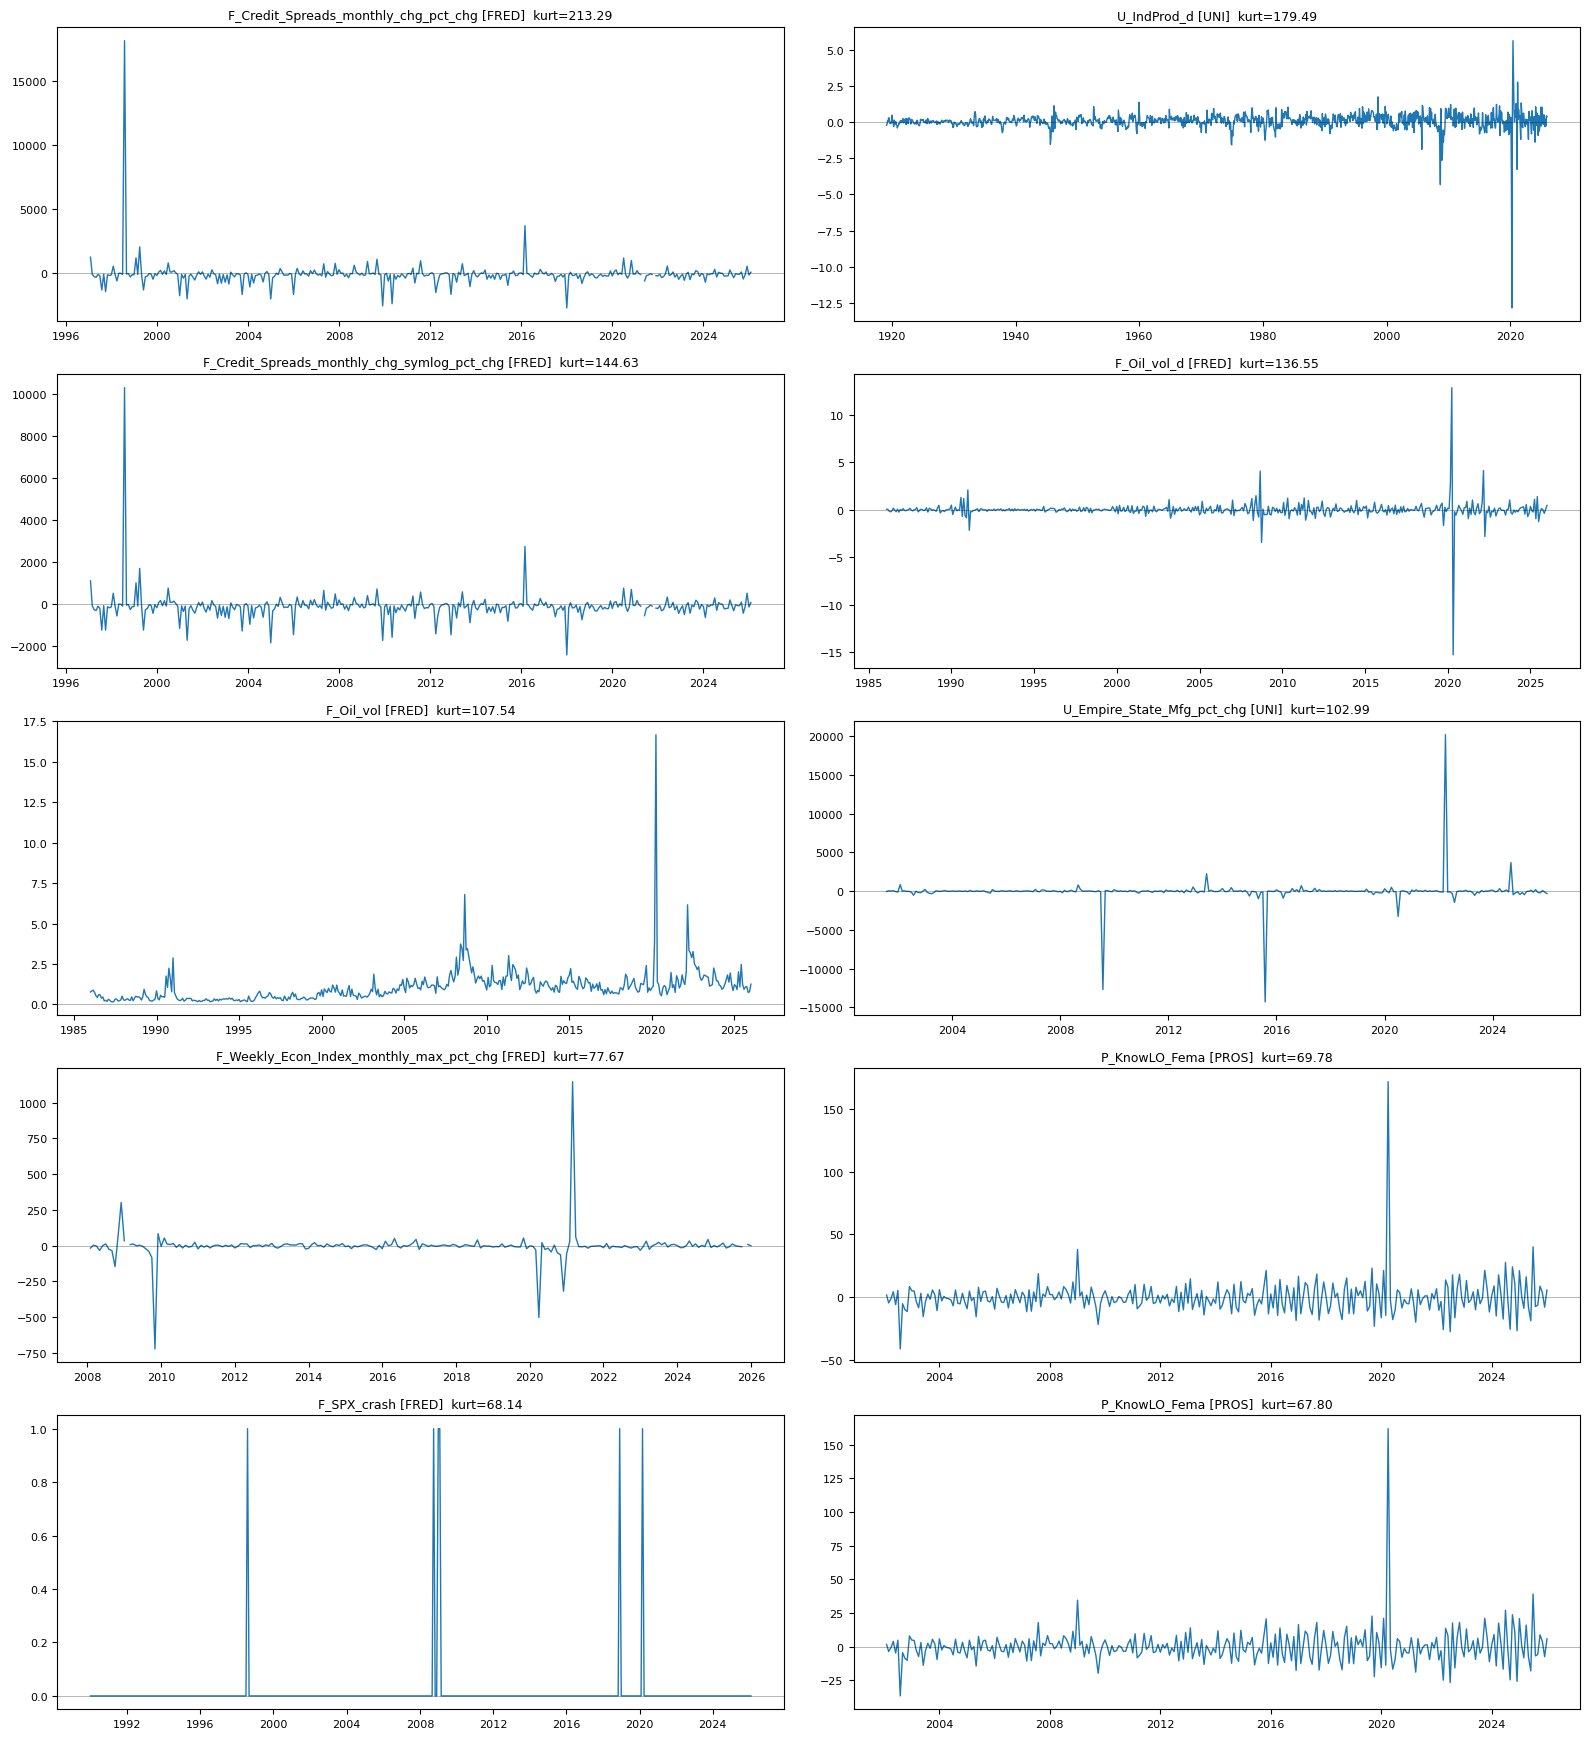

In [132]:
# Skew/kurtosis/scale for all series across sources
# Kurtosis is excess (Fisher) as returned by pandas.Series.kurt()
from IPython.display import display

analysis_wide = wide_all.sort_index()

def scale_bucket(med_abs):
    if pd.isna(med_abs):
        return 'NA', np.nan
    if med_abs == 0:
        return '0s', 0
    if med_abs < 1:
        return '<1', -1
    mag = int(np.floor(np.log10(med_abs)))
    labels = {
        0: '1s',
        1: '10s',
        2: '100s',
        3: '1,000s',
        4: '10,000s',
        5: '100,000s',
        6: 'Millions',
        7: '10 Millions',
        8: '100 Millions',
        9: 'Billions',
        10: '10 Billions',
    }
    return labels.get(mag, f'10^{mag}'), mag

rows = []
for col in analysis_wide.columns:
    s = analysis_wide[col].replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(s)
    if n_obs == 0:
        rows.append({
            'feature': col,
            'short_name': name_map.get(col, col[:30]),
            'source': source_map.get(col, '?'),
            'n_obs': 0,
            'skew': np.nan,
            'kurtosis': np.nan,
            'abs_kurtosis': np.nan,
            'median_abs': np.nan,
            'scale_power': np.nan,
            'scale': 'NA',
        })
        continue

    med_abs = s.abs().median()
    scale_label, scale_pow = scale_bucket(med_abs)
    kurt = s.kurt()
    rows.append({
        'feature': col,
        'short_name': name_map.get(col, col[:30]),
        'source': source_map.get(col, '?'),
        'n_obs': n_obs,
        'skew': s.skew(),
        'kurtosis': kurt,
        'abs_kurtosis': abs(kurt) if pd.notna(kurt) else np.nan,
        'median_abs': med_abs,
        'scale_power': scale_pow,
        'scale': scale_label,
    })

stats_df = pd.DataFrame(rows)
stats_df = stats_df.sort_values('abs_kurtosis', ascending=False).reset_index(drop=True)

out_path = Path('feature_skew_kurtosis_scale.csv')
stats_df.to_csv(out_path, index=False)
print(f'Saved {out_path} with {len(stats_df)} rows')
display(stats_df)

# Plot 10 series with worst (highest absolute) kurtosis
top_kurt = stats_df.dropna(subset=['abs_kurtosis']).head(10)
n = len(top_kurt)
ncols = 2
nrows = int(np.ceil(n / ncols)) if n > 0 else 1
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.5 * nrows))
axes = np.atleast_1d(axes).ravel()

for ax in axes[n:]:
    ax.axis('off')

for i, (_, row) in enumerate(top_kurt.iterrows()):
    col = row['feature']
    s = analysis_wide[col]
    ax = axes[i]
    ax.plot(s.index, s.values, linewidth=1)
    ax.set_title(f"{row['short_name']} [{row['source']}]  kurt={row['kurtosis']:.2f}", fontsize=9)
    ax.axhline(0, color='black', linewidth=0.5, alpha=0.4)
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


Found 4 housing-related features
['Housing_Starts', 'Housing_Starts_diff', 'Housing_Starts_diff_zscore_12m', 'Housing_Starts_diff_zscore_3m']


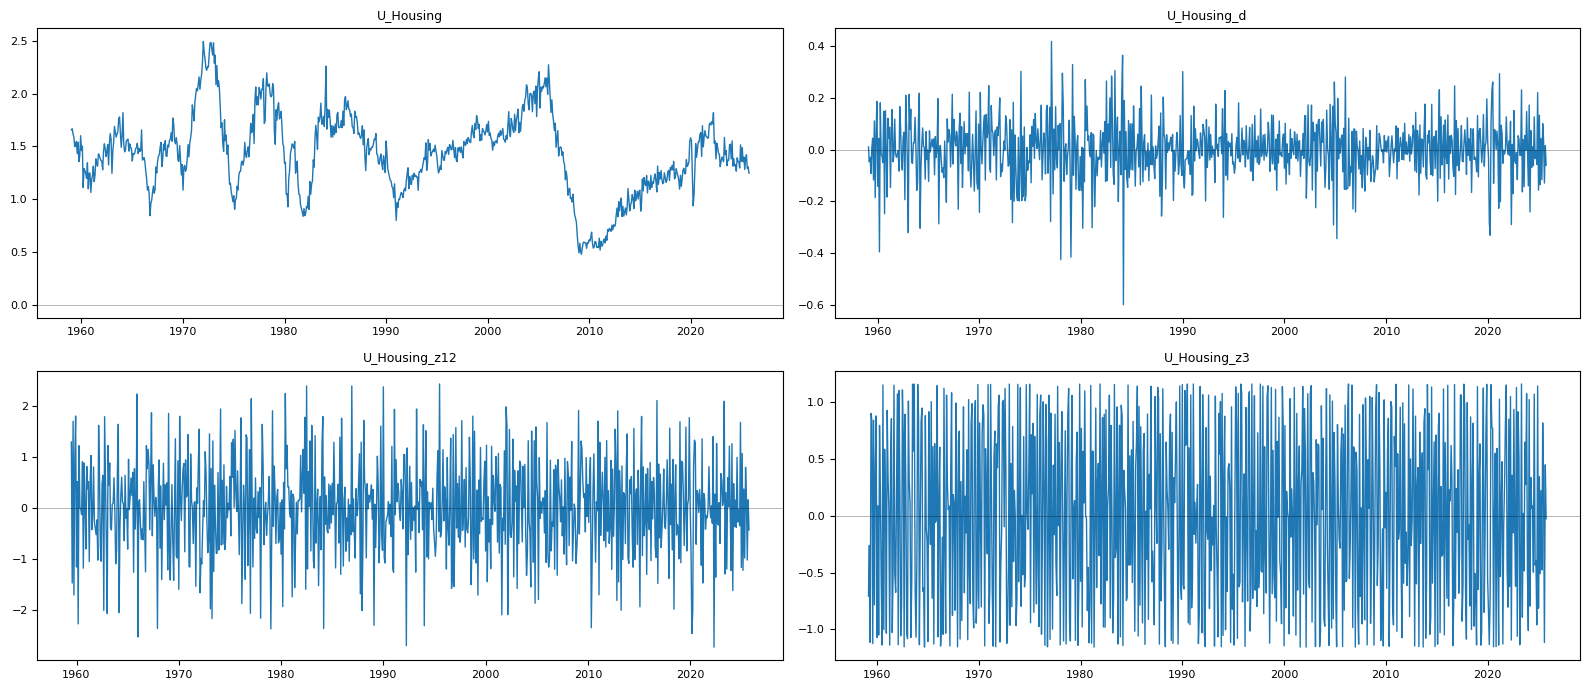

In [ ]:
# Plot all features with "Housing" in the name (from wide_all)
housing_cols = [c for c in wide_all.columns if 'housing' in c.lower()]

print(f'Found {len(housing_cols)} housing-related features')
print(housing_cols)

if housing_cols:
    n = len(housing_cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.5 * nrows))
    axes = np.atleast_1d(axes).ravel()

    for ax in axes[n:]:
        ax.axis('off')

    for i, col in enumerate(housing_cols):
        s = wide_all[col]
        axes[i].plot(s.index, s.values, linewidth=1)
        title = name_map.get(col, col)
        axes[i].set_title(title, fontsize=9)
        axes[i].axhline(0, color='black', linewidth=0.5, alpha=0.4)
        axes[i].tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()


In [ ]:
# Plot all Prosper unemployment series (short name contains "P_Unemp")
pros_unemp_cols = [c for c in wide_all.columns if 'P_' in name_map.get(c, '')]

print(f'Found {len(pros_unemp_cols)} Prosper unemployment features')
print([name_map.get(c, c) for c in pros_unemp_cols])

if pros_unemp_cols:
    n = len(pros_unemp_cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.5 * nrows))
    axes = np.atleast_1d(axes).ravel()

    for ax in axes[n:]:
        ax.axis('off')

    for i, col in enumerate(pros_unemp_cols):
        s = wide_all[col]
        axes[i].plot(s.index, s.values, linewidth=1)
        title = name_map.get(col, col)
        axes[i].set_title(title, fontsize=9)
        axes[i].axhline(0, color='black', linewidth=0.5, alpha=0.4)
        axes[i].tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()


Found 0 Prosper unemployment features
[]


In [ ]:
def get_series_by_short_name(short_name, wide_df=wide_all, name_map=name_map, source_map=source_map):
    """
    Return a DataFrame for a single feature by its short name.
    Example: get_series_by_short_name("P_Mood_F")
    """
    # Find matching full feature name(s)
    matches = [full for full, short in name_map.items() if short == short_name]
    if not matches:
        raise KeyError(f"No series found for short name: {short_name}")
    if len(matches) > 1:
        raise ValueError(f"Multiple series match {short_name}: {matches}")
    
    feature = matches[0]
    df = wide_df[[feature]].copy()
    df = df.rename(columns={feature: short_name})
    df['feature'] = feature
    df['source'] = source_map.get(feature, '?')
    return df

df = get_series_by_short_name("P_Unemp_F")
df


series_name  P_Unemp_F                                            feature source
date                                                                            
1919-01-01         NaN  Which of the following most accurately describ...   PROS
1919-02-01         NaN  Which of the following most accurately describ...   PROS
1919-03-01         NaN  Which of the following most accurately describ...   PROS
1919-04-01         NaN  Which of the following most accurately describ...   PROS
1919-05-01         NaN  Which of the following most accurately describ...   PROS
...                ...                                                ...    ...
2025-10-01    0.185694  Which of the following most accurately describ...   PROS
2025-11-01    0.176915  Which of the following most accurately describ...   PROS
2025-12-01    0.179294  Which of the following most accurately describ...   PROS
2026-01-01    0.182013  Which of the following most accurately describ...   PROS
2026-02-01         NaN  Which of the following most accurately describ...   PROS

[1286 rows x 3 columns]

Using latest master snapshot: /Users/dhruvkohli/Desktop/Github Repos/NFP_Predictor/data/Exogenous_data/master_snapshots/decades/2020s/2026/2026-01.parquet


series_name          mean      skew    kurtosis  n_obs  mean_symlog  skew_symlog  kurtosis_symlog  n_obs_symlog     diff_mean     diff_skew  diff_kurtosis  \
0                           Industrial_Production_diff  7.595565e-02 -7.848393  179.490221   1283     0.069128    -0.787476         6.752431          1283 -6.827851e-03  7.060917e+00  -1.727378e+02   
1                           Oil_Prices_volatility_diff  1.011079e-03 -2.359573  136.552143    480    -0.003087     0.186944        13.459245           480 -4.097785e-03  2.546517e+00  -1.230929e+02   
2                                Oil_Prices_volatility  1.040541e+00  7.926270  107.544914    481     0.645025     1.131043         3.862140           481 -3.955154e-01 -6.795227e+00  -1.036828e+02   
3                                           ADP_actual  1.450471e+05 -8.584718   90.549801    191    10.050305    -2.994087         7.301575           191 -1.450371e+05  5.590632e+00  -8.324823e+01   
4                                     CCSA_monthly_avg  2.945093e+06  6.276311   49.451251    430    14.802301     1.870331         7.279519           430 -2.945078e+06 -4.405980e+00  -4.217173e+01   
5                           NOAA_Economic_Damage_Index  2.865001e+01 -1.297190    1.854432    430     3.350829    -5.096468        43.226791           430 -2.529918e+01 -3.799278e+00   4.137236e+01   
6                                  Challenger_Job_Cuts  6.715186e+04  4.820186   40.306240    385    10.919614     0.540312         0.786359           385 -6.714094e+04 -4.279873e+00  -3.951988e+01   
7                             Challenger_Job_Cuts_diff -1.210938e+00  1.895212   34.770648    384    -0.539075     0.117986        -1.923387           384  6.718621e-01 -1.777227e+00  -3.669403e+01   
8                   Weekly_Econ_Index_monthly_max_diff  2.523364e-03 -0.213131   34.410572    214    -0.010662     0.433547         5.292706           214 -1.318506e-02  6.466777e-01  -2.911787e+01   
9                                     AHE_Private_diff  5.550847e-03  5.691988   61.934203    236     0.004905     4.199346        41.538249           236 -6.463068e-04 -1.492642e+00  -2.039595e+01   
10                             Credit_Spreads_avg_diff -1.116176e-03  2.018277   22.289609    349    -0.015258     0.594614         3.516222           349 -1.414200e-02 -1.423663e+00  -1.877339e+01   
11                                 SP500_best_day_diff -1.689537e-03  1.119743   11.509596    432    -0.015544     0.233759         0.779243           432 -1.385492e-02 -8.859838e-01  -1.073035e+01   
12                                    VIX_max_5d_spike  1.259984e+00  3.610473   20.105826    433     0.811312     2.680689        11.424646           433 -4.486717e-01 -9.297842e-01  -8.681180e+00   
13   Which of the following most accurately describ... -1.259759e-03 -4.916028   67.275209    288    -0.001216    -4.339759        58.857251           288  4.346434e-05  5.762686e-01  -8.417957e+00   
14                                  Credit_Spreads_avg  5.201706e+00  2.500178    9.273268    350     1.763539     0.981327         1.192947           350 -3.438167e+00 -1.518851e+00  -8.080321e+00   
15                     Credit_Spreads_accel_volatility  1.039660e-01  3.633904   21.960084    349     0.097241     2.889203        14.211527           349 -6.725276e-03 -7.447018e-01  -7.748557e+00   
16                             Yield_Curve_monthly_chg  4.362416e-04  0.788779   10.281363    596    -0.000697     0.321186         3.388091           596 -1.133677e-03 -4.675930e-01  -6.893272e+00   
17                     Credit_Spreads_monthly_chg_diff  1.432665e-04 -1.183361    7.434867    349     0.013126    -0.316664         0.656390           349  1.298279e-02  8.666967e-01  -6.778478e+00   
18                               VIX_max_5d_spike_diff -9.931070e-05  0.355662   10.041932    432    -0.000803     0.149673         3.785213           432 -7.038564e-04 -2.059888e-01  -6.256719e+00   
19                     

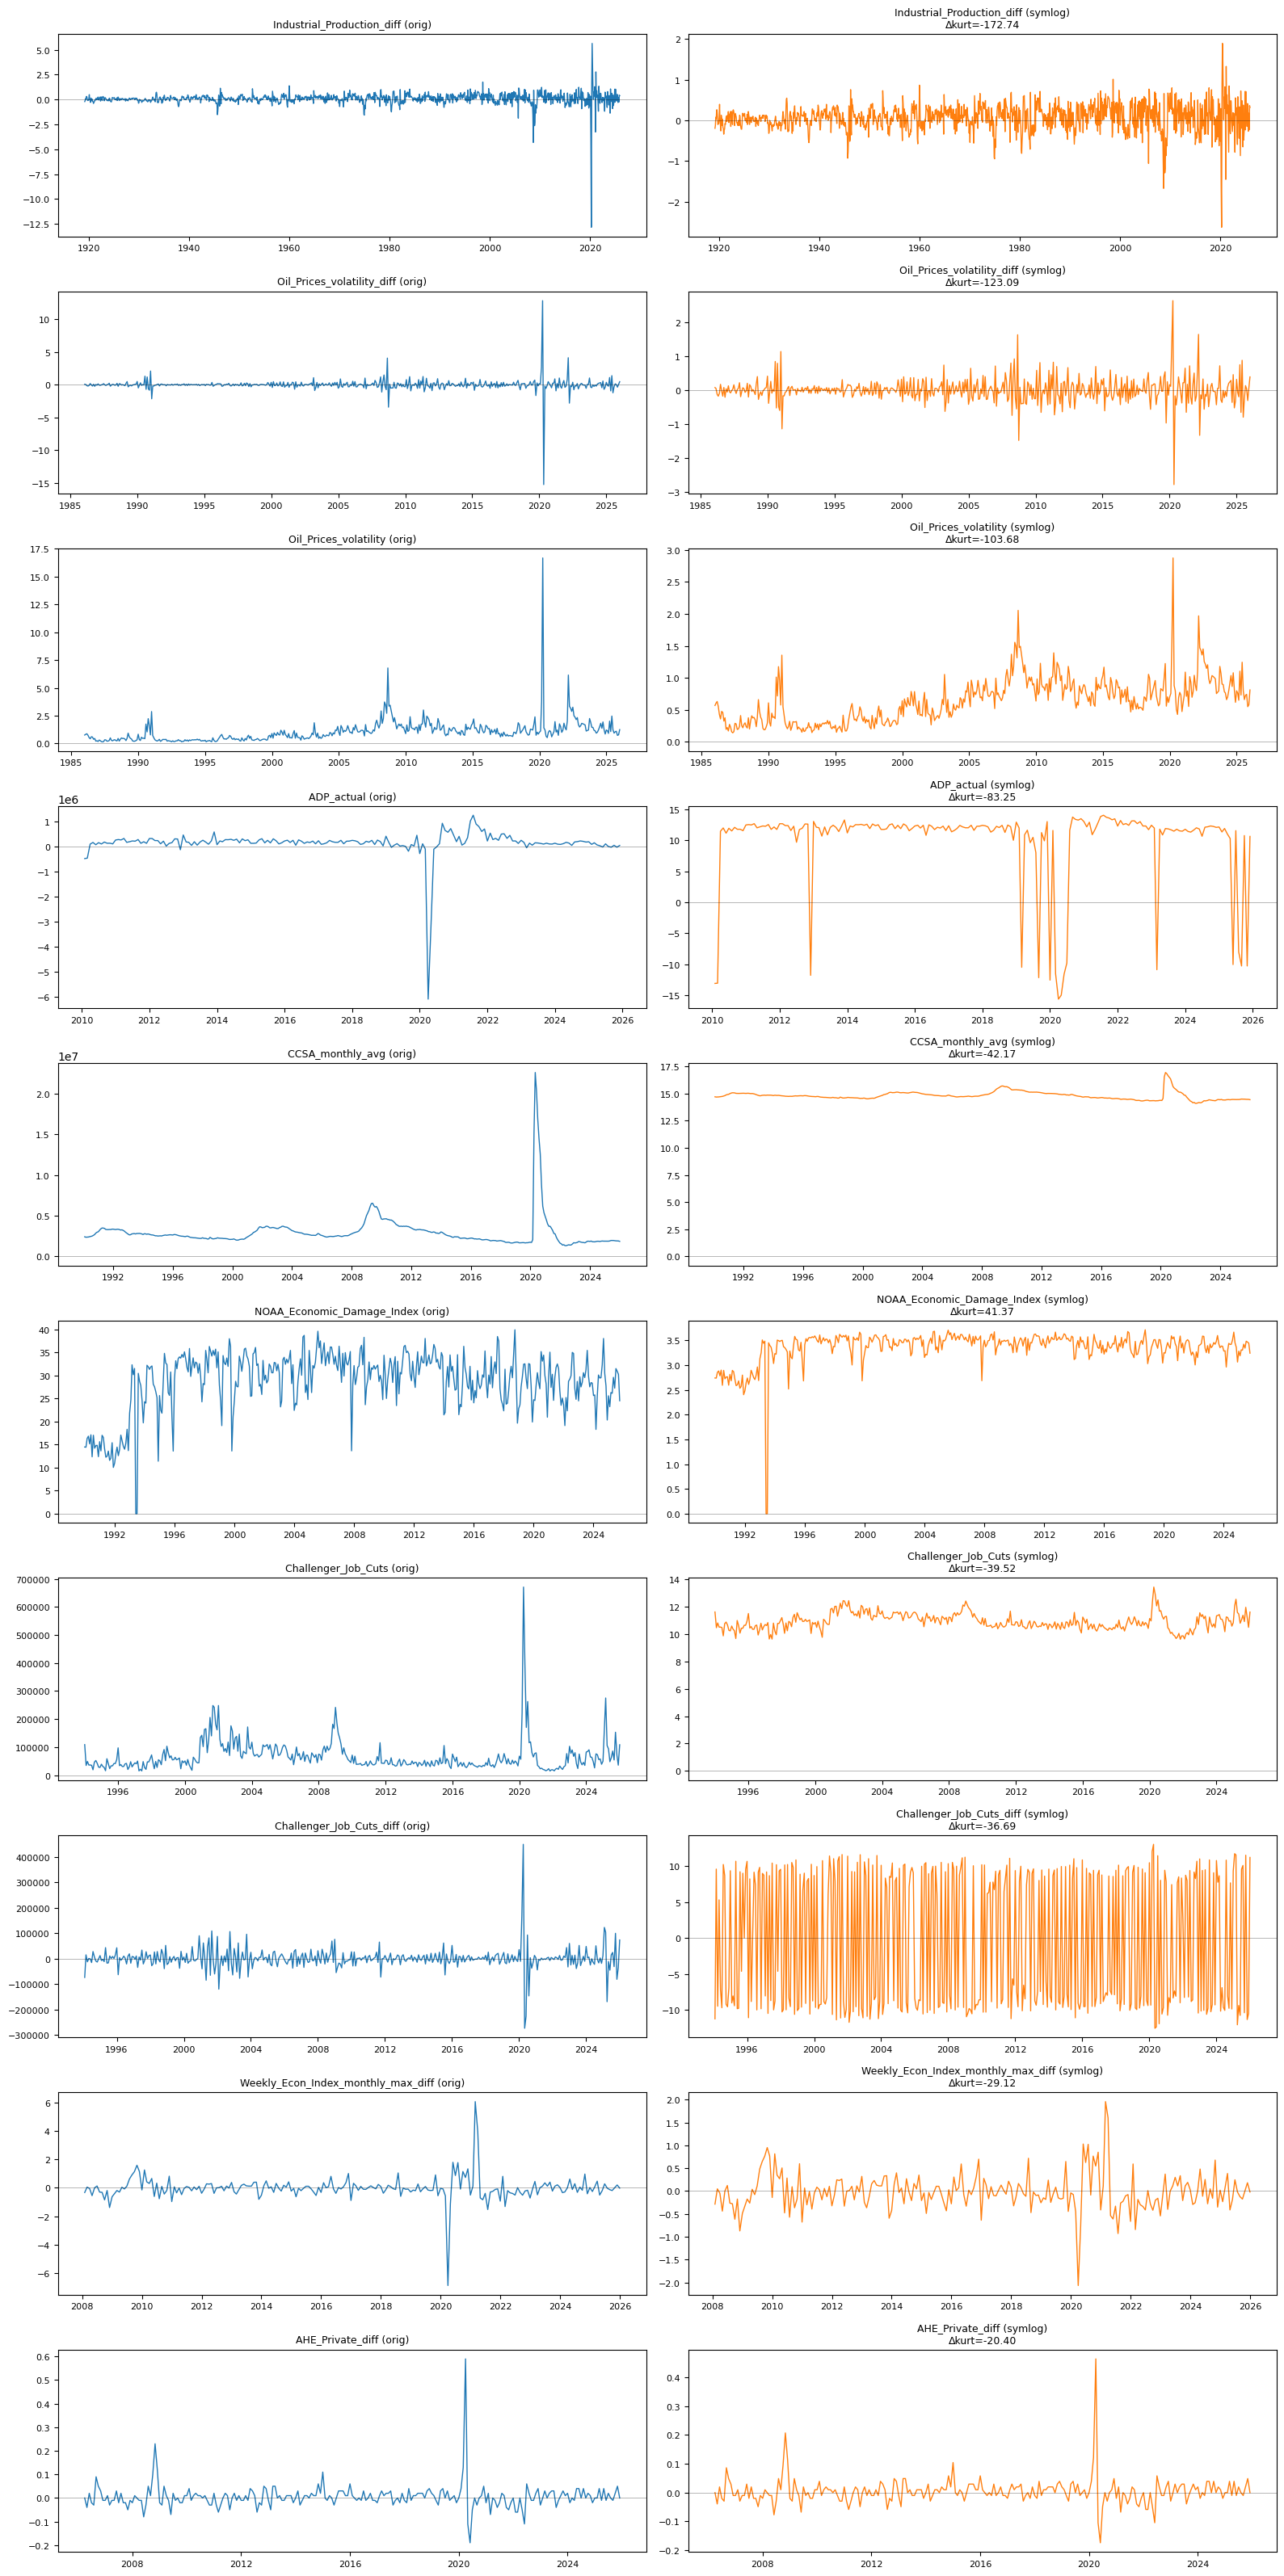

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

# --- Locate latest master snapshot ---
try:
    from settings import DATA_PATH
    master_root = Path(DATA_PATH) / "Exogenous_data" / "master_snapshots" / "decades"
except Exception:
    master_root = Path("data/Exogenous_data/master_snapshots/decades")

files = list(master_root.rglob("*.parquet"))
if not files:
    raise FileNotFoundError(f"No master snapshots found under: {master_root}")

def file_to_date(p: Path) -> pd.Timestamp:
    # filename like YYYY-MM.parquet
    return pd.to_datetime(p.stem, format="%Y-%m")

latest_file = max(files, key=file_to_date)
print(f"Using latest master snapshot: {latest_file}")

df = pd.read_parquet(latest_file)
df['date'] = pd.to_datetime(df['date'])

# --- Compute stats for each series ---
def series_stats(s: pd.Series):
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if len(s) == 0:
        return pd.Series({'mean': np.nan, 'skew': np.nan, 'kurtosis': np.nan, 'n_obs': 0})
    return pd.Series({
        'mean': s.mean(),
        'skew': s.skew(),
        'kurtosis': s.kurt(),  # pandas: excess kurtosis
        'n_obs': len(s)
    })

# Clean values
df['value'] = df['value'].replace([np.inf, -np.inf], np.nan)

# Robust stats table (guaranteed column names)
stats = (
    df.groupby('series_name')['value']
      .agg(
          mean='mean',
          skew=pd.Series.skew,
          kurtosis=pd.Series.kurt,   # excess kurtosis
          n_obs='count'
      )
      .reset_index()
)

# Split original vs symlog
orig = stats[~stats['series_name'].str.endswith('_symlog')].copy()
sym  = stats[stats['series_name'].str.endswith('_symlog')].copy()
sym['series_name'] = sym['series_name'].str.replace('_symlog$', '', regex=True)

# Merge pairs
compare = orig.merge(sym, on='series_name', how='inner', suffixes=('', '_symlog'))

# Diffs
compare['diff_mean'] = compare['mean_symlog'] - compare['mean']
compare['diff_skew'] = compare['skew_symlog'] - compare['skew']
compare['diff_kurtosis'] = compare['kurtosis_symlog'] - compare['kurtosis']
compare['abs_diff_kurtosis'] = compare['diff_kurtosis'].abs()


compare = compare.sort_values('abs_diff_kurtosis', ascending=False).reset_index(drop=True)

# Show full comparison dataframe
display(compare)

# --- Plot top N by absolute kurtosis difference ---
top_n = 10
top = compare.head(top_n)

nrows = len(top)
fig, axes = plt.subplots(nrows, 2, figsize=(16, 3.2 * nrows), sharex=False)

if nrows == 1:
    axes = np.array([axes])  # ensure 2D

for i, row in top.iterrows():
    name = row['series_name']
    orig_s = df[df['series_name'] == name].sort_values('date')
    sym_s  = df[df['series_name'] == f"{name}_symlog"].sort_values('date')

    ax0 = axes[i, 0]
    ax1 = axes[i, 1]

    ax0.plot(orig_s['date'], orig_s['value'], linewidth=1)
    ax0.set_title(f"{name} (orig)", fontsize=9)
    ax0.axhline(0, color='black', linewidth=0.5, alpha=0.4)
    ax0.tick_params(labelsize=8)

    ax1.plot(sym_s['date'], sym_s['value'], linewidth=1, color='tab:orange')
    ax1.set_title(f"{name} (symlog)\nΔkurt={row['diff_kurtosis']:.2f}", fontsize=9)
    ax1.axhline(0, color='black', linewidth=0.5, alpha=0.4)
    ax1.tick_params(labelsize=8)

plt.tight_layout()
plt.show()
